
# Hull Tactical – Full Assignment Notebook (Analyze + Submit in One)

This notebook is organized to satisfy the assignment structure **by steps**,
while keeping the **original working code logic for both analysis and the
Kaggle evaluation API** almost unchanged.

구성:

- **Step 0. Kaggle 환경 설정 (선택, Kaggle에서만 필요)**  
- **Step 1. 기본 라이브러리 Import**
- **Step 2. 데이터 로드 & 간단 확인**
- **Step 3. EDA 유틸 함수 정의 & 실행**
- **Step 4. CONFIG 설정 (경로, 피처 리스트 등)**
- **Step 5. Feature Engineering 함수 정의**
- **Step 6. LightGBM + Optuna 모델 학습**
- **Step 7. Feature Importance 시각화**
- **Step 8. Kaggle Evaluation API용 `predict()` 및 Inference Server**


## Step 0. (Kaggle 전용) Competition 데이터 마운트 / kagglehub 로그인

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

hull_tactical_market_prediction_path = kagglehub.competition_download('hull-tactical-market-prediction')

print('Data source import complete.')


Data source import complete.


## Step 1. 라이브러리 Import

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import optuna
import warnings
import polars as pl
import gc
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
from scipy.stats import spearmanr
import joblib
import kaggle_evaluation.default_inference_server
from sklearn.model_selection import TimeSeriesSplit
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

## Step 2. 데이터 로드 & 기본 확인

In [4]:
train_df = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
test_df =pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')

In [5]:
train_df.head(5)

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


## Step 3. EDA 유틸 함수 정의 & 실행

In [6]:
def describe_dataset(df: pd.DataFrame):
    """
    Provides a comprehensive, structured overview of a DataFrame, including
    dimensions, memory usage, data types, and detailed descriptive statistics.

    Args:
        df (pd.DataFrame): The input DataFrame to describe.
    """

    display(Markdown("## 📋 Dataset Overview"))
    print("--- Basic Dimensions & Memory ---")

    # shape
    num_rows, num_cols = df.shape
    print(f"**Shape (Rows, Columns):** ({num_rows:,}, {num_cols:,})")

    # memory
    mem_usage = df.memory_usage(deep=True).sum()
    mem_gbs = mem_usage / (1024**2)
    print(f"**Total Memory Usage:** {mem_gbs:.2f} MB")

    print("\n--- Feature Data Types and Counts ---")

    # 2. data types
    dtype_counts = df.dtypes.astype(str).value_counts().reset_index()
    dtype_counts.columns = ['Data_Type', 'Count']
    print(dtype_counts.to_markdown(index=False))


    # stats
    display(Markdown("\n## 📊 Descriptive Statistics"))

    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime']).columns.tolist()

    # numerical
    if numerical_cols:
        display(Markdown("### Numerical Features"))
        # Use transpose for better readability when many features exist
        num_desc = df[numerical_cols].describe().T
        # Add IQR for a more detailed statistical view
        num_desc['IQR'] = num_desc['75%'] - num_desc['25%']
        display(num_desc.style.format("{:,.2f}"))
        print(f"Found {len(numerical_cols)} numerical features.")

    # categorical
    if categorical_cols:
        display(Markdown("### Categorical / Object Features"))
        # Include top, frequency, and unique count
        cat_desc = df[categorical_cols].describe().T
        display(cat_desc.style.format({"unique": "{:,}", "freq": "{:,}"}))
        print(f"Found {len(categorical_cols)} categorical/object features.")

    # datetime
    if datetime_cols:
        display(Markdown("### Datetime Features"))
        dt_desc = df[datetime_cols].describe().T
        display(dt_desc)
        print(f"Found {len(datetime_cols)} datetime features.")


def missing_duplicates_analysis(df: pd.DataFrame, top_n: int = 20) -> pd.DataFrame:
    print("--- 📊 Missing Data and Duplicates Analysis ---")
    # missing summary
    missing_counts = df.isnull().sum()
    missing_summary = pd.DataFrame({
        'Missing_Count': missing_counts,
        'Missing_Percent': 100 * missing_counts / len(df)
    })
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]
    missing_summary = missing_summary.sort_values(by='Missing_Count', ascending=False)


    # check for duplicates
    num_duplicates = df.duplicated().sum()
    print(f"**Duplicate rows found:** {df.duplicated().sum()}")

    # visualisation
    if missing_summary.empty:
        print("✅ **No missing values found** in the dataset.")
        return pd.DataFrame()

    print(f"\n**Total features with missing values:** {len(missing_summary)}")

    # Select the top n features
    plot_data = missing_summary.head(top_n)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=plot_data.index,
        y='Missing_Count',
        data=plot_data,
        palette='viridis'
    )

    # Add percentage labels above the bars
    for i, count in enumerate(plot_data['Missing_Count']):
        percent = plot_data['Missing_Percent'].iloc[i]
        plt.text(
            x=i,
            y=count + (df.shape[0] * 0.005),
            s=f'{percent:.1f}%',
            ha='center',
            fontsize=9
        )

    plt.title(f"Top {min(top_n, len(missing_summary))} Features by Missing Values Count (Total Rows: {len(df)})",
              fontsize=14, fontweight='bold')
    plt.xlabel("Feature Name", fontsize=12)
    plt.ylabel("Missing Count", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\n**Missing Data Summary Table (Top 10):**")
    print(missing_summary.head(10).to_markdown(floatfmt=".2f"))
    return missing_summary


def detect_outliers(df, method='iqr', threshold=2.5, z_threshold=3.0, cols=None, summary=True):

    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if method not in ['iqr', 'zscore']:
        raise ValueError("method must be 'iqr' or 'zscore'")

    outlier_flags = pd.DataFrame(False, index=df.index, columns=cols)

    for col in cols:
        series = df[col].dropna()

        if method == 'iqr':
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            outlier_flags[col] = (df[col] < lower_bound) | (df[col] > upper_bound)

        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(series))
            outlier_flags[col] = z_scores > z_threshold

    if summary:
        summary_df = pd.DataFrame({
            'outlier_count': outlier_flags.sum(),
            'percent_outliers': 100 * outlier_flags.sum() / len(df)
        }).sort_values('percent_outliers', ascending=False)

        print("📊 Outlier Detection Summary:")
        print(summary_df.round(2))
        return outlier_flags, summary_df

    return outlier_flags

In [7]:
describe_dataset(train_df)

## 📋 Dataset Overview

--- Basic Dimensions & Memory ---
**Shape (Rows, Columns):** (9,021, 98)
**Total Memory Usage:** 6.74 MB

--- Feature Data Types and Counts ---
| Data_Type   |   Count |
|:------------|--------:|
| float64     |      88 |
| int64       |      10 |



## 📊 Descriptive Statistics

### Numerical Features

,count,mean,std,min,25%,50%,75%,max,IQR
date_id,"9,021.00","4,510.00","2,604.28",0.00,"2,255.00","4,510.00","6,765.00","9,020.00","4,510.00"
D1,"9,021.00",0.03,0.17,0.00,0.00,0.00,0.00,1.00,0.00
D2,"9,021.00",0.03,0.17,0.00,0.00,0.00,0.00,1.00,0.00
D3,"9,021.00",0.05,0.21,0.00,0.00,0.00,0.00,1.00,0.00
D4,"9,021.00",0.57,0.49,0.00,0.00,1.00,1.00,1.00,1.00
D5,"9,021.00",0.19,0.39,0.00,0.00,0.00,0.00,1.00,0.00
D6,"9,021.00",-0.24,0.43,-1.00,0.00,0.00,0.00,0.00,0.00
D7,"9,021.00",0.05,0.21,0.00,0.00,0.00,0.00,1.00,0.00
D8,"9,021.00",0.14,0.35,0.00,0.00,0.00,0.00,1.00,0.00
D9,"9,021.00",0.14,0.35,0.00,0.00,0.00,0.00,1.00,0.00


Found 98 numerical features.


--- 📊 Missing Data and Duplicates Analysis ---
**Duplicate rows found:** 0

**Total features with missing values:** 85


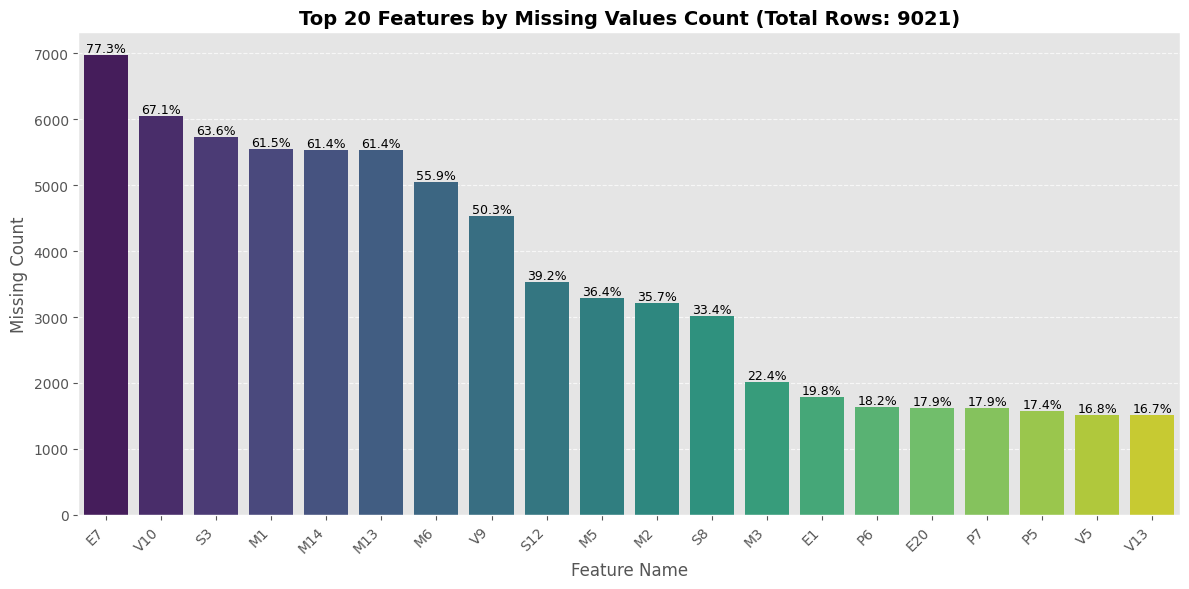


**Missing Data Summary Table (Top 10):**
|     |   Missing_Count |   Missing_Percent |
|:----|----------------:|------------------:|
| E7  |         6969.00 |             77.25 |
| V10 |         6049.00 |             67.05 |
| S3  |         5733.00 |             63.55 |
| M1  |         5547.00 |             61.49 |
| M14 |         5540.00 |             61.41 |
| M13 |         5540.00 |             61.41 |
| M6  |         5043.00 |             55.90 |
| V9  |         4539.00 |             50.32 |
| S12 |         3537.00 |             39.21 |
| M5  |         3283.00 |             36.39 |


In [8]:
missing_df_summary = missing_duplicates_analysis(train_df)

In [9]:
outliers, summary = detect_outliers(train_df, method='iqr')

📊 Outlier Detection Summary:
                               outlier_count  percent_outliers
D6                                      2148             23.81
D5                                      1718             19.04
E4                                      1396             15.48
D9                                      1290             14.30
D8                                      1287             14.27
E12                                     1129             12.52
E11                                     1032             11.44
E6                                       992             11.00
E14                                      632              7.01
P6                                       553              6.13
S5                                       498              5.52
D3                                       431              4.78
E13                                      414              4.59
D7                                       412              4.57
D2                        

## Step 4. CONFIG 설정 (경로, 피처 리스트, 하이퍼파라미터 관련 상수)

### CONFIG

In [10]:
TRAIN_PATH = '/kaggle/input/hull-tactical-market-prediction/train.csv'
LOCAL_GATEWAY_PATH = '/kaggle/input/hull-tactical-market-prediction/'
MODEL_PATH = 'lgbm_model.cbm'
FEATURES_PATH = 'features.joblib'

TOP_FEATURES_FOR_FE = ['M4', 'V13', 'S5', 'S2', 'D2', 'E19', 'P7', 'P6', 'P3', 'P13', 'P4', 'P5', 'M2', 'V5']
LAG_PERIODS = [1, 3, 5, 7, 14, 20]
ROLLING_WINDOWS = [2, 5, 10, 20, 60]

TARGET = 'market_forward_excess_returns'
COLS_TO_DROP = ['forward_returns', 'risk_free_rate', 'excess_return', 'E7', 'V10', 'S3', 'M1', 'M14']
BEST_C = 0.5

## Step 5. Feature Engineering 함수 정의

In [11]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:

    for col in TOP_FEATURES_FOR_FE:
        if col in df.columns:
            for lag in LAG_PERIODS:
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
            for window in ROLLING_WINDOWS:
                df[f'{col}_roll_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
                df[f'{col}_roll_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()

    df.ffill(inplace=True)
    for col in df.columns:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val if not np.isnan(median_val) else 0, inplace=True)

    return df

## Step 6. LightGBM + Optuna 모델 학습 및 저장

In [12]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="lightgbm")

if not os.path.exists(MODEL_PATH):
    print("Model not found. Starting training process...")

    train_df = pd.read_csv(TRAIN_PATH)
    if 'date_id' not in train_df.columns:
        train_df['date_id'] = train_df.index
    train_df.drop(columns=[col for col in COLS_TO_DROP if col in train_df.columns], inplace=True)

    train_featured = create_features(train_df)
    train_featured.dropna(subset=[TARGET], inplace=True)

    FEATURES = [col for col in train_featured.columns if col not in [TARGET, 'date_id']]
    X = train_featured[FEATURES]
    y = train_featured[TARGET]

    def objective(trial):
        params = {
            "objective": "regression",
            "metric": "rmse",
            "n_estimators": trial.suggest_int("n_estimators", 500, 7000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.07, log=True),
            "max_depth": trial.suggest_int("max_depth", 5, 12),
            "num_leaves": trial.suggest_int("num_leaves", 32, 4012),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "subsample_freq": 1,
            "random_state": 42,
            "verbosity": -1
        }

        tscv = TimeSeriesSplit(n_splits=4)
        scores = []

        for train_index, val_index in tscv.split(X):
            model_opt = LGBMRegressor(**params)
            model_opt.fit(
                X.iloc[train_index],
                y.iloc[train_index],
                eval_set=[(X.iloc[val_index], y.iloc[val_index])],
                eval_metric="rmse",
                callbacks=[
                    early_stopping(200),
                    log_evaluation(-1)
                ]
            )

            preds = model_opt.predict(X.iloc[val_index])
            score, _ = spearmanr(y.iloc[val_index], preds)
            scores.append(score)

        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=200, timeout=5400)

    print(f"Best params found: {study.best_params}")

    final_model = LGBMRegressor(**study.best_params, random_state=42)
    final_model.fit(X, y)

    joblib.dump(final_model, MODEL_PATH)
    joblib.dump(FEATURES, FEATURES_PATH)

    print("Training complete. Model and features saved.")

else:
    print("Model training skipped: Model file already exists.")


Model not found. Starting training process...


[I 2025-12-03 17:22:07,767] A new study created in memory with name: no-name-408cf835-1f24-432f-9ae0-4ae59ec9935a


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.00882564
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:22:11,284] Trial 0 failed with parameters: {'n_estimators': 992, 'learning_rate': 0.027576759111874034, 'max_depth': 8, 'num_leaves': 823, 'reg_lambda': 1.2727758696762415, 'reg_alpha': 1.9088055740231538, 'colsample_bytree': 0.9423067154781464, 'subsample': 0.8317171411771443} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:22:11,285] Trial 0 failed with value nan.


Early stopping, best iteration is:
[40]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 0.0127762
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116228
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.00882159
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:22:27,346] Trial 1 finished with value: 0.05852648568200842 and parameters: {'n_estimators': 5076, 'learning_rate': 0.023185299608918172, 'max_depth': 9, 'num_leaves': 2898, 'reg_lambda': 0.0017218250030104803, 'reg_alpha': 0.0496877012233582, 'colsample_bytree': 0.7161760372892241, 'subsample': 0.6743906826136417}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[20]	valid_0's rmse: 0.0110906
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1114]	valid_0's rmse: 0.0128277
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.0116216
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 0.00880594
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:22:37,222] Trial 2 finished with value: 0.02332236940879729 and parameters: {'n_estimators': 5396, 'learning_rate': 0.04583866167100447, 'max_depth': 11, 'num_leaves': 3350, 'reg_lambda': 0.003784064804092218, 'reg_alpha': 0.5000435752072896, 'colsample_bytree': 0.9278608480221814, 'subsample': 0.8139020491305919}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[7]	valid_0's rmse: 0.0111199
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.0128099
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116376
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.00880448
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:22:48,212] Trial 3 finished with value: 0.03573686139213568 and parameters: {'n_estimators': 3470, 'learning_rate': 0.06985824153558921, 'max_depth': 6, 'num_leaves': 2848, 'reg_lambda': 0.002062456945687663, 'reg_alpha': 0.003328782711678957, 'colsample_bytree': 0.7267241705986913, 'subsample': 0.8653516581634018}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[22]	valid_0's rmse: 0.0111011
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[879]	valid_0's rmse: 0.012808
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 0.0116239
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.00881068
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:22:58,263] Trial 4 finished with value: 0.0295519366671922 and parameters: {'n_estimators': 3789, 'learning_rate': 0.03954028316778244, 'max_depth': 12, 'num_leaves': 2456, 'reg_lambda': 0.004058788898310859, 'reg_alpha': 0.32726898159274453, 'colsample_bytree': 0.7944080514311873, 'subsample': 0.7001015829309196}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0111181
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2651]	valid_0's rmse: 0.0128138
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 0.0116189
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[160]	valid_0's rmse: 0.00880893
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:23:10,955] Trial 5 finished with value: 0.045929462477081906 and parameters: {'n_estimators': 3538, 'learning_rate': 0.010565571809858931, 'max_depth': 11, 'num_leaves': 1148, 'reg_lambda': 6.716739833697839, 'reg_alpha': 0.3454883239573305, 'colsample_bytree': 0.7692839341534653, 'subsample': 0.6081942044553511}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[68]	valid_0's rmse: 0.0111064
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 0.0116189
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	valid_0's rmse: 0.00881455
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:23:16,547] Trial 6 failed with parameters: {'n_estimators': 1759, 'learning_rate': 0.013785479088159696, 'max_depth': 12, 'num_leaves': 2091, 'reg_lambda': 0.0065343607508273616, 'reg_alpha': 0.737698198044407, 'colsample_bytree': 0.9436198892159467, 'subsample': 0.7050780346254747} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:23:16,548] Trial 6 failed with value nan.


Early stopping, best iteration is:
[65]	valid_0's rmse: 0.011113
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 0.012799
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.011622
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.00881822
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:23:31,605] Trial 7 finished with value: 0.040916624098598156 and parameters: {'n_estimators': 6848, 'learning_rate': 0.01592094786345335, 'max_depth': 10, 'num_leaves': 697, 'reg_lambda': 3.0544740368374153, 'reg_alpha': 0.0018263681468841124, 'colsample_bytree': 0.9326496427988569, 'subsample': 0.6006887230229345}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[14]	valid_0's rmse: 0.0111095
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 0.0127989
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116215
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.00878157
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:23:40,634] Trial 8 finished with value: 0.05049587784555975 and parameters: {'n_estimators': 3092, 'learning_rate': 0.05659011927551006, 'max_depth': 6, 'num_leaves': 128, 'reg_lambda': 0.001108235413169354, 'reg_alpha': 0.005585396142226069, 'colsample_bytree': 0.71236569990355, 'subsample': 0.9702557678818716}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[8]	valid_0's rmse: 0.0111193
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:23:43,793] Trial 9 failed with parameters: {'n_estimators': 2061, 'learning_rate': 0.01789317698450069, 'max_depth': 8, 'num_leaves': 2003, 'reg_lambda': 0.028942145976917476, 'reg_alpha': 6.593558966455156, 'colsample_bytree': 0.973805812693082, 'subsample': 0.7585676899937664} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:23:43,794] Trial 9 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.0127998
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116313
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.00880292
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:23:58,991] Trial 10 finished with value: 0.038932425084211006 and parameters: {'n_estimators': 1616, 'learning_rate': 0.05987962713006239, 'max_depth': 8, 'num_leaves': 3048, 'reg_lambda': 0.022004632393464063, 'reg_alpha': 0.010279248363965252, 'colsample_bytree': 0.6809219009154127, 'subsample': 0.9609061462309781}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[4]	valid_0's rmse: 0.0110859
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:24:02,688] Trial 11 failed with parameters: {'n_estimators': 2744, 'learning_rate': 0.03453720552127838, 'max_depth': 5, 'num_leaves': 2952, 'reg_lambda': 8.53867842089718, 'reg_alpha': 2.1394423499623616, 'colsample_bytree': 0.7424617633625447, 'subsample': 0.9016990715312402} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:24:02,689] Trial 11 failed with value nan.


Early stopping, best iteration is:
[91]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:24:05,852] Trial 12 failed with parameters: {'n_estimators': 6054, 'learning_rate': 0.03870779065501084, 'max_depth': 7, 'num_leaves': 2705, 'reg_lambda': 0.022057679420191458, 'reg_alpha': 2.067975907517187, 'colsample_bytree': 0.7614779620012353, 'subsample': 0.7771819592834788} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:24:05,853] Trial 12 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[503]	valid_0's rmse: 0.00882454
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:24:09,141] Trial 13 failed with parameters: {'n_estimators': 4905, 'learning_rate': 0.010028863508141365, 'max_depth': 10, 'num_leaves': 669, 'reg_lambda': 3.6224961191793046, 'reg_alpha': 1.5915338710788505, 'colsample_bytree': 0.7522802207201478, 'subsample': 0.76639428487843} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:24:09,142] Trial 13 failed with value nan.


Early stopping, best iteration is:
[12]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[234]	valid_0's rmse: 0.0127943
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.0116188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	valid_0's rmse: 0.00880729
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:24:27,656] Trial 14 finished with value: 0.05275826387864617 and parameters: {'n_estimators': 5954, 'learning_rate': 0.011411436435630265, 'max_depth': 9, 'num_leaves': 3868, 'reg_lambda': 1.1818946232326164, 'reg_alpha': 0.07976569417841746, 'colsample_bytree': 0.6366387530782494, 'subsample': 0.8548384564230334}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[7]	valid_0's rmse: 0.011116
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[990]	valid_0's rmse: 0.0127981
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 0.0116181
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 0.00880253
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:24:43,836] Trial 15 finished with value: 0.04668332887706896 and parameters: {'n_estimators': 5493, 'learning_rate': 0.01858593282206647, 'max_depth': 12, 'num_leaves': 4011, 'reg_lambda': 2.2512829671242836, 'reg_alpha': 0.2171822135894797, 'colsample_bytree': 0.6505481423248717, 'subsample': 0.8599386058684211}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[8]	valid_0's rmse: 0.0111155
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:24:46,650] Trial 16 failed with parameters: {'n_estimators': 1064, 'learning_rate': 0.027959464474935577, 'max_depth': 8, 'num_leaves': 1604, 'reg_lambda': 0.16611906426382894, 'reg_alpha': 4.403753540622624, 'colsample_bytree': 0.8715708169640506, 'subsample': 0.7001006461721591} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:24:46,651] Trial 16 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:24:49,506] Trial 17 failed with parameters: {'n_estimators': 763, 'learning_rate': 0.02778812637568536, 'max_depth': 8, 'num_leaves': 1735, 'reg_lambda': 0.09542892160756812, 'reg_alpha': 9.592531630297705, 'colsample_bytree': 0.87029585510665, 'subsample': 0.7299115477410726} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:24:49,507] Trial 17 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:24:52,351] Trial 18 failed with parameters: {'n_estimators': 1245, 'learning_rate': 0.027837052589109533, 'max_depth': 8, 'num_leaves': 1774, 'reg_lambda': 0.1564122314788385, 'reg_alpha': 5.718138894103871, 'colsample_bytree': 0.857821060759783, 'subsample': 0.7091558474235848} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:24:52,351] Trial 18 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:24:55,224] Trial 19 failed with parameters: {'n_estimators': 668, 'learning_rate': 0.030126926736946686, 'max_depth': 8, 'num_leaves': 1760, 'reg_lambda': 0.17874556509063158, 'reg_alpha': 6.988666048802107, 'colsample_bytree': 0.8600527471781856, 'subsample': 0.7127825924595631} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:24:55,225] Trial 19 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:24:58,051] Trial 20 failed with parameters: {'n_estimators': 663, 'learning_rate': 0.0268427130745367, 'max_depth': 8, 'num_leaves': 1696, 'reg_lambda': 0.11619772405210413, 'reg_alpha': 3.764599724534131, 'colsample_bytree': 0.8497230580678654, 'subsample': 0.7131185922100657} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:24:58,052] Trial 20 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:00,932] Trial 21 failed with parameters: {'n_estimators': 1536, 'learning_rate': 0.02833908258625912, 'max_depth': 8, 'num_leaves': 1777, 'reg_lambda': 0.13242105146468042, 'reg_alpha': 7.17576802982457, 'colsample_bytree': 0.860459907780166, 'subsample': 0.7117888018334986} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:00,933] Trial 21 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:03,904] Trial 22 failed with parameters: {'n_estimators': 513, 'learning_rate': 0.028875303568526692, 'max_depth': 8, 'num_leaves': 1848, 'reg_lambda': 0.10028062782847612, 'reg_alpha': 5.125752913950171, 'colsample_bytree': 0.8587951879983289, 'subsample': 0.7198018869313978} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:03,904] Trial 22 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:06,795] Trial 23 failed with parameters: {'n_estimators': 1044, 'learning_rate': 0.025707588547028915, 'max_depth': 8, 'num_leaves': 1814, 'reg_lambda': 0.16211071789753348, 'reg_alpha': 9.211351693015953, 'colsample_bytree': 0.8671953651348026, 'subsample': 0.723579651796235} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:06,796] Trial 23 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:09,584] Trial 24 failed with parameters: {'n_estimators': 558, 'learning_rate': 0.027479559558354127, 'max_depth': 7, 'num_leaves': 1602, 'reg_lambda': 0.16735637945489495, 'reg_alpha': 4.295842706003218, 'colsample_bytree': 0.8609361476466699, 'subsample': 0.7101070030423218} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:09,585] Trial 24 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:12,432] Trial 25 failed with parameters: {'n_estimators': 848, 'learning_rate': 0.0270903245972945, 'max_depth': 8, 'num_leaves': 1766, 'reg_lambda': 0.15173847223401374, 'reg_alpha': 7.491618852104788, 'colsample_bytree': 0.869598783457106, 'subsample': 0.7030398086289507} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:12,433] Trial 25 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:15,414] Trial 26 failed with parameters: {'n_estimators': 1049, 'learning_rate': 0.030134395276245597, 'max_depth': 8, 'num_leaves': 1947, 'reg_lambda': 0.14462117882154624, 'reg_alpha': 7.96370390701491, 'colsample_bytree': 0.8666104881504311, 'subsample': 0.7072705138140148} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:15,415] Trial 26 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:18,276] Trial 27 failed with parameters: {'n_estimators': 1377, 'learning_rate': 0.02867083547521074, 'max_depth': 8, 'num_leaves': 1777, 'reg_lambda': 0.24236837101433648, 'reg_alpha': 6.338733048280131, 'colsample_bytree': 0.8739391107435294, 'subsample': 0.7126860743839153} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:18,277] Trial 27 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:21,200] Trial 28 failed with parameters: {'n_estimators': 687, 'learning_rate': 0.024943163313419114, 'max_depth': 8, 'num_leaves': 1924, 'reg_lambda': 0.07841893156710439, 'reg_alpha': 7.7043189730299515, 'colsample_bytree': 0.8567551762239454, 'subsample': 0.6949662022872488} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:21,201] Trial 28 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:24,115] Trial 29 failed with parameters: {'n_estimators': 890, 'learning_rate': 0.02776081415256766, 'max_depth': 8, 'num_leaves': 1788, 'reg_lambda': 0.14691980367688684, 'reg_alpha': 5.97046785707508, 'colsample_bytree': 0.8542991733508162, 'subsample': 0.712356294181412} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:24,116] Trial 29 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:27,018] Trial 30 failed with parameters: {'n_estimators': 615, 'learning_rate': 0.030569757355216443, 'max_depth': 8, 'num_leaves': 1756, 'reg_lambda': 0.19752553639347473, 'reg_alpha': 7.189954705074652, 'colsample_bytree': 0.8799755264614663, 'subsample': 0.7133687042118808} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:27,019] Trial 30 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:29,856] Trial 31 failed with parameters: {'n_estimators': 669, 'learning_rate': 0.02748216845803493, 'max_depth': 8, 'num_leaves': 1726, 'reg_lambda': 0.16406569186011782, 'reg_alpha': 6.14768994305868, 'colsample_bytree': 0.8651816709044367, 'subsample': 0.7037889291435817} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:29,857] Trial 31 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:32,817] Trial 32 failed with parameters: {'n_estimators': 693, 'learning_rate': 0.027603104022764304, 'max_depth': 8, 'num_leaves': 1907, 'reg_lambda': 0.14558934487700126, 'reg_alpha': 2.807403568617241, 'colsample_bytree': 0.8650489776134661, 'subsample': 0.7192824840609315} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:32,818] Trial 32 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:35,676] Trial 33 failed with parameters: {'n_estimators': 524, 'learning_rate': 0.02800313343847423, 'max_depth': 8, 'num_leaves': 1798, 'reg_lambda': 0.13861018965417643, 'reg_alpha': 3.599825672271578, 'colsample_bytree': 0.8661545068331544, 'subsample': 0.7171563217952638} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:35,677] Trial 33 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:38,567] Trial 34 failed with parameters: {'n_estimators': 1084, 'learning_rate': 0.02698624257394681, 'max_depth': 8, 'num_leaves': 1772, 'reg_lambda': 0.10834547790069127, 'reg_alpha': 7.758712539015909, 'colsample_bytree': 0.8807144334142069, 'subsample': 0.7103404987367916} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:38,567] Trial 34 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:41,424] Trial 35 failed with parameters: {'n_estimators': 1135, 'learning_rate': 0.026836383458749172, 'max_depth': 8, 'num_leaves': 1717, 'reg_lambda': 0.19661320472269397, 'reg_alpha': 9.820362831392295, 'colsample_bytree': 0.8599229165810585, 'subsample': 0.7084560112988524} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:41,425] Trial 35 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:44,306] Trial 36 failed with parameters: {'n_estimators': 863, 'learning_rate': 0.028243055364912756, 'max_depth': 8, 'num_leaves': 1688, 'reg_lambda': 0.1531963506834385, 'reg_alpha': 2.150737742148602, 'colsample_bytree': 0.8641213664692582, 'subsample': 0.7100353340900033} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:44,307] Trial 36 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:47,104] Trial 37 failed with parameters: {'n_estimators': 901, 'learning_rate': 0.02850697030498786, 'max_depth': 8, 'num_leaves': 1699, 'reg_lambda': 0.15750539077216436, 'reg_alpha': 3.3443645593675404, 'colsample_bytree': 0.8314551298636044, 'subsample': 0.7137658407716816} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:47,104] Trial 37 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:49,938] Trial 38 failed with parameters: {'n_estimators': 531, 'learning_rate': 0.02794590368661331, 'max_depth': 8, 'num_leaves': 1725, 'reg_lambda': 0.14343682384628376, 'reg_alpha': 7.266549740229417, 'colsample_bytree': 0.8597438650629543, 'subsample': 0.7039659305098439} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:49,939] Trial 38 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:52,856] Trial 39 failed with parameters: {'n_estimators': 692, 'learning_rate': 0.02786155850766575, 'max_depth': 8, 'num_leaves': 1808, 'reg_lambda': 0.19666197302266106, 'reg_alpha': 9.299875809219902, 'colsample_bytree': 0.8628606675810124, 'subsample': 0.7005902402485198} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:52,857] Trial 39 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:55,732] Trial 40 failed with parameters: {'n_estimators': 1168, 'learning_rate': 0.030260342824617932, 'max_depth': 8, 'num_leaves': 1840, 'reg_lambda': 0.10543078037498727, 'reg_alpha': 9.713500483093915, 'colsample_bytree': 0.85643608433074, 'subsample': 0.7090417897153088} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:55,733] Trial 40 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:25:58,584] Trial 41 failed with parameters: {'n_estimators': 693, 'learning_rate': 0.02744124917163332, 'max_depth': 8, 'num_leaves': 1667, 'reg_lambda': 0.13368434644750923, 'reg_alpha': 5.82900732588974, 'colsample_bytree': 0.8498090560729237, 'subsample': 0.7119649457578846} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:25:58,585] Trial 41 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:01,472] Trial 42 failed with parameters: {'n_estimators': 927, 'learning_rate': 0.027902521851925353, 'max_depth': 8, 'num_leaves': 1796, 'reg_lambda': 0.16244855162770458, 'reg_alpha': 7.650466449146583, 'colsample_bytree': 0.8480447426945293, 'subsample': 0.7055368235282209} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:01,473] Trial 42 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:04,458] Trial 43 failed with parameters: {'n_estimators': 712, 'learning_rate': 0.02688615456188222, 'max_depth': 8, 'num_leaves': 1780, 'reg_lambda': 0.183496502481627, 'reg_alpha': 6.3063045116345275, 'colsample_bytree': 0.8614844490542648, 'subsample': 0.7128756507201667} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:04,459] Trial 43 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:07,355] Trial 44 failed with parameters: {'n_estimators': 1473, 'learning_rate': 0.027752045096665845, 'max_depth': 8, 'num_leaves': 1717, 'reg_lambda': 0.2429330216107981, 'reg_alpha': 7.452605566794273, 'colsample_bytree': 0.8709892481463971, 'subsample': 0.7130118337363768} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:07,356] Trial 44 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:10,395] Trial 45 failed with parameters: {'n_estimators': 897, 'learning_rate': 0.027530677120155434, 'max_depth': 8, 'num_leaves': 1702, 'reg_lambda': 0.1334957811946303, 'reg_alpha': 4.07405161914322, 'colsample_bytree': 0.998556230320583, 'subsample': 0.7103463888942593} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:10,396] Trial 45 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:13,257] Trial 46 failed with parameters: {'n_estimators': 1076, 'learning_rate': 0.026292270937198124, 'max_depth': 8, 'num_leaves': 1771, 'reg_lambda': 0.22112504331709806, 'reg_alpha': 3.4917781054277452, 'colsample_bytree': 0.8519417740318228, 'subsample': 0.7094117846575745} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:13,258] Trial 46 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:16,000] Trial 47 failed with parameters: {'n_estimators': 1557, 'learning_rate': 0.027536551695036146, 'max_depth': 8, 'num_leaves': 1554, 'reg_lambda': 0.1520190667381443, 'reg_alpha': 6.2762305810058745, 'colsample_bytree': 0.8585669731845245, 'subsample': 0.7115747466151958} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:16,001] Trial 47 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:18,780] Trial 48 failed with parameters: {'n_estimators': 511, 'learning_rate': 0.02601870372259896, 'max_depth': 8, 'num_leaves': 1615, 'reg_lambda': 0.12486956460886914, 'reg_alpha': 9.334746767697494, 'colsample_bytree': 0.8546692930055977, 'subsample': 0.7169026963464207} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:18,781] Trial 48 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:21,631] Trial 49 failed with parameters: {'n_estimators': 1020, 'learning_rate': 0.02949348164431005, 'max_depth': 8, 'num_leaves': 1730, 'reg_lambda': 0.16939806756091436, 'reg_alpha': 7.937673942310628, 'colsample_bytree': 0.8642978452668264, 'subsample': 0.7315676620858191} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:21,632] Trial 49 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:24,528] Trial 50 failed with parameters: {'n_estimators': 756, 'learning_rate': 0.028846529957612825, 'max_depth': 8, 'num_leaves': 1698, 'reg_lambda': 0.19489754612617108, 'reg_alpha': 3.71701948539184, 'colsample_bytree': 0.8626915359822885, 'subsample': 0.7447885641044875} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:24,529] Trial 50 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:27,447] Trial 51 failed with parameters: {'n_estimators': 857, 'learning_rate': 0.02788771806622328, 'max_depth': 8, 'num_leaves': 2035, 'reg_lambda': 0.15995356183282358, 'reg_alpha': 7.312975950110747, 'colsample_bytree': 0.8366709954391887, 'subsample': 0.713513463842717} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:27,448] Trial 51 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:30,299] Trial 52 failed with parameters: {'n_estimators': 1022, 'learning_rate': 0.02632417700734902, 'max_depth': 8, 'num_leaves': 1744, 'reg_lambda': 0.1589126017426881, 'reg_alpha': 8.0858603475171, 'colsample_bytree': 0.8612581114960024, 'subsample': 0.7197913344368785} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:30,300] Trial 52 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:33,176] Trial 53 failed with parameters: {'n_estimators': 890, 'learning_rate': 0.026546938209381477, 'max_depth': 8, 'num_leaves': 1771, 'reg_lambda': 0.18138849215242658, 'reg_alpha': 7.536453959110954, 'colsample_bytree': 0.8412692822544416, 'subsample': 0.721244093079032} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:33,177] Trial 53 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	valid_0's rmse: 0.0128015
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 0.0116185
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.00881358
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:26:48,339] Trial 54 finished with value: 0.05154217612844532 and parameters: {'n_estimators': 511, 'learning_rate': 0.030781591130016998, 'max_depth': 8, 'num_leaves': 1790, 'reg_lambda': 0.05844108666416718, 'reg_alpha': 0.05576236511934136, 'colsample_bytree': 0.8683706620383917, 'subsample': 0.709864849722054}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[17]	valid_0's rmse: 0.0110972
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:52,016] Trial 55 failed with parameters: {'n_estimators': 5571, 'learning_rate': 0.01017679422319856, 'max_depth': 9, 'num_leaves': 4008, 'reg_lambda': 0.35008225975498464, 'reg_alpha': 2.8189699487011484, 'colsample_bytree': 0.6259278891302532, 'subsample': 0.7357679499544547} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:52,017] Trial 55 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:55,779] Trial 56 failed with parameters: {'n_estimators': 5338, 'learning_rate': 0.010048719742088416, 'max_depth': 9, 'num_leaves': 3990, 'reg_lambda': 0.567242090476927, 'reg_alpha': 6.681221482733158, 'colsample_bytree': 0.6037279399716663, 'subsample': 0.7310116502538901} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:55,780] Trial 56 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:26:59,453] Trial 57 failed with parameters: {'n_estimators': 5607, 'learning_rate': 0.011307398505255936, 'max_depth': 9, 'num_leaves': 3962, 'reg_lambda': 0.39311858922731097, 'reg_alpha': 6.192040545408753, 'colsample_bytree': 0.6029496658084893, 'subsample': 0.7136081346288682} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:26:59,454] Trial 57 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:02,826] Trial 58 failed with parameters: {'n_estimators': 5658, 'learning_rate': 0.011052501818080523, 'max_depth': 9, 'num_leaves': 3630, 'reg_lambda': 0.49146665679282964, 'reg_alpha': 8.298694141741072, 'colsample_bytree': 0.615932001849185, 'subsample': 0.7592231790359915} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:02,827] Trial 58 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:06,362] Trial 59 failed with parameters: {'n_estimators': 5518, 'learning_rate': 0.010292851622212058, 'max_depth': 9, 'num_leaves': 3823, 'reg_lambda': 0.4446388774311165, 'reg_alpha': 8.169937495577763, 'colsample_bytree': 0.6138493761631015, 'subsample': 0.7243910356969566} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:06,363] Trial 59 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:10,160] Trial 60 failed with parameters: {'n_estimators': 5599, 'learning_rate': 0.010274403715099523, 'max_depth': 9, 'num_leaves': 3934, 'reg_lambda': 0.30743516153831746, 'reg_alpha': 5.015556754261151, 'colsample_bytree': 0.6005170688018223, 'subsample': 0.7270222309283092} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:10,161] Trial 60 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:13,858] Trial 61 failed with parameters: {'n_estimators': 5569, 'learning_rate': 0.01992518816602055, 'max_depth': 9, 'num_leaves': 3972, 'reg_lambda': 0.49400745814557384, 'reg_alpha': 8.226007463439528, 'colsample_bytree': 0.628418270116517, 'subsample': 0.7242401074396193} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:13,859] Trial 61 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:17,472] Trial 62 failed with parameters: {'n_estimators': 5593, 'learning_rate': 0.011574114172707919, 'max_depth': 9, 'num_leaves': 3977, 'reg_lambda': 0.42099315525342196, 'reg_alpha': 2.2196068396777853, 'colsample_bytree': 0.6148341690784471, 'subsample': 0.7328646411058739} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:17,473] Trial 62 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:21,158] Trial 63 failed with parameters: {'n_estimators': 5445, 'learning_rate': 0.010110016935689508, 'max_depth': 9, 'num_leaves': 3943, 'reg_lambda': 0.4696211476427002, 'reg_alpha': 6.590883644168696, 'colsample_bytree': 0.6074349120642719, 'subsample': 0.7320801492547012} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:21,159] Trial 63 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:24,733] Trial 64 failed with parameters: {'n_estimators': 5678, 'learning_rate': 0.010478459111025783, 'max_depth': 9, 'num_leaves': 3936, 'reg_lambda': 0.45630227955701136, 'reg_alpha': 7.35558659204457, 'colsample_bytree': 0.6012323472338228, 'subsample': 0.7323384294447657} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:24,734] Trial 64 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:28,382] Trial 65 failed with parameters: {'n_estimators': 5544, 'learning_rate': 0.010794064326076727, 'max_depth': 9, 'num_leaves': 3925, 'reg_lambda': 0.6050904847153747, 'reg_alpha': 8.62723751406265, 'colsample_bytree': 0.6383617539641449, 'subsample': 0.7295587208054425} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:28,383] Trial 65 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:31,873] Trial 66 failed with parameters: {'n_estimators': 5655, 'learning_rate': 0.010985048015828584, 'max_depth': 9, 'num_leaves': 3849, 'reg_lambda': 0.4419765706950322, 'reg_alpha': 5.719906534186026, 'colsample_bytree': 0.6030368126570492, 'subsample': 0.7324535312601316} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:31,874] Trial 66 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:35,530] Trial 67 failed with parameters: {'n_estimators': 5584, 'learning_rate': 0.011569315401605705, 'max_depth': 9, 'num_leaves': 3880, 'reg_lambda': 0.617803194947681, 'reg_alpha': 9.278670376965595, 'colsample_bytree': 0.6039497421177087, 'subsample': 0.7298612199063459} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:35,531] Trial 67 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:39,037] Trial 68 failed with parameters: {'n_estimators': 5586, 'learning_rate': 0.010259603494453103, 'max_depth': 9, 'num_leaves': 3824, 'reg_lambda': 0.2698166137132467, 'reg_alpha': 5.86165824271406, 'colsample_bytree': 0.607792715953333, 'subsample': 0.7211599371179144} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:39,038] Trial 68 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:42,674] Trial 69 failed with parameters: {'n_estimators': 5574, 'learning_rate': 0.010087056756530188, 'max_depth': 9, 'num_leaves': 3994, 'reg_lambda': 0.25819081754629297, 'reg_alpha': 8.059587266625481, 'colsample_bytree': 0.6017067110688495, 'subsample': 0.7115378096032532} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:42,677] Trial 69 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:46,250] Trial 70 failed with parameters: {'n_estimators': 5553, 'learning_rate': 0.010822714887595094, 'max_depth': 9, 'num_leaves': 3879, 'reg_lambda': 0.45725719283237665, 'reg_alpha': 2.335072390359915, 'colsample_bytree': 0.6053463938324924, 'subsample': 0.7248884326886298} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:46,251] Trial 70 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:49,884] Trial 71 failed with parameters: {'n_estimators': 5573, 'learning_rate': 0.011001509491156686, 'max_depth': 9, 'num_leaves': 3943, 'reg_lambda': 0.42187245578428884, 'reg_alpha': 6.417636576249914, 'colsample_bytree': 0.6040421616565911, 'subsample': 0.7355284773147469} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:49,885] Trial 71 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:53,501] Trial 72 failed with parameters: {'n_estimators': 5527, 'learning_rate': 0.010233277219769884, 'max_depth': 9, 'num_leaves': 3965, 'reg_lambda': 0.3713041449036472, 'reg_alpha': 7.1370137044876065, 'colsample_bytree': 0.6199037891175012, 'subsample': 0.7247119742741658} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:53,502] Trial 72 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:27:57,086] Trial 73 failed with parameters: {'n_estimators': 5429, 'learning_rate': 0.010358156690709294, 'max_depth': 9, 'num_leaves': 3925, 'reg_lambda': 0.44303012665222574, 'reg_alpha': 6.328428457093653, 'colsample_bytree': 0.6057340960450945, 'subsample': 0.7260450958492943} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:27:57,087] Trial 73 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:00,677] Trial 74 failed with parameters: {'n_estimators': 5629, 'learning_rate': 0.010294305063073387, 'max_depth': 9, 'num_leaves': 3976, 'reg_lambda': 0.5079210117114829, 'reg_alpha': 7.594856191746349, 'colsample_bytree': 0.6122667276473708, 'subsample': 0.7290379372893417} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:00,677] Trial 74 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:04,293] Trial 75 failed with parameters: {'n_estimators': 5582, 'learning_rate': 0.010203327930761959, 'max_depth': 9, 'num_leaves': 3985, 'reg_lambda': 0.5916412489653989, 'reg_alpha': 6.527070039753043, 'colsample_bytree': 0.6256045182980696, 'subsample': 0.7228855273656206} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:04,294] Trial 75 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:07,913] Trial 76 failed with parameters: {'n_estimators': 5416, 'learning_rate': 0.010157026704597148, 'max_depth': 9, 'num_leaves': 4004, 'reg_lambda': 0.4727346271536906, 'reg_alpha': 9.113270657119536, 'colsample_bytree': 0.6128181493649769, 'subsample': 0.7012326670131295} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:07,914] Trial 76 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:11,505] Trial 77 failed with parameters: {'n_estimators': 5592, 'learning_rate': 0.010324171683964824, 'max_depth': 9, 'num_leaves': 3879, 'reg_lambda': 0.4366749597857783, 'reg_alpha': 9.622716565736498, 'colsample_bytree': 0.6132115028771157, 'subsample': 0.7325935298460484} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:11,506] Trial 77 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:15,054] Trial 78 failed with parameters: {'n_estimators': 5281, 'learning_rate': 0.010747725478695904, 'max_depth': 9, 'num_leaves': 3843, 'reg_lambda': 0.5944832025844932, 'reg_alpha': 6.208840997087199, 'colsample_bytree': 0.6136582332413865, 'subsample': 0.7350794330022071} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:15,055] Trial 78 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:18,589] Trial 79 failed with parameters: {'n_estimators': 5550, 'learning_rate': 0.010577316391407215, 'max_depth': 9, 'num_leaves': 3874, 'reg_lambda': 0.4879764853958798, 'reg_alpha': 7.623537231865093, 'colsample_bytree': 0.6053960442838957, 'subsample': 0.7270878735654911} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:18,590] Trial 79 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:22,154] Trial 80 failed with parameters: {'n_estimators': 5519, 'learning_rate': 0.011332068477397622, 'max_depth': 9, 'num_leaves': 3964, 'reg_lambda': 0.43613080035505836, 'reg_alpha': 5.891142496862554, 'colsample_bytree': 0.6046607084751934, 'subsample': 0.7297914434905688} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:22,155] Trial 80 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:25,701] Trial 81 failed with parameters: {'n_estimators': 5522, 'learning_rate': 0.010006042144434773, 'max_depth': 9, 'num_leaves': 3833, 'reg_lambda': 0.45481789955448026, 'reg_alpha': 5.834203488761272, 'colsample_bytree': 0.6117073246282418, 'subsample': 0.737363427918136} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:25,702] Trial 81 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:29,316] Trial 82 failed with parameters: {'n_estimators': 5419, 'learning_rate': 0.010196523270021298, 'max_depth': 9, 'num_leaves': 4000, 'reg_lambda': 0.6290020014445904, 'reg_alpha': 6.242184861116898, 'colsample_bytree': 0.610935530095003, 'subsample': 0.7228886176283856} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:29,317] Trial 82 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:32,917] Trial 83 failed with parameters: {'n_estimators': 5653, 'learning_rate': 0.010242967144677874, 'max_depth': 9, 'num_leaves': 3950, 'reg_lambda': 0.4613875564230395, 'reg_alpha': 4.652311932208665, 'colsample_bytree': 0.6018613965486487, 'subsample': 0.7357071814437995} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:32,918] Trial 83 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:36,467] Trial 84 failed with parameters: {'n_estimators': 5616, 'learning_rate': 0.019250853935315143, 'max_depth': 9, 'num_leaves': 3945, 'reg_lambda': 0.42415584689220237, 'reg_alpha': 6.448353864278363, 'colsample_bytree': 0.6156990632568096, 'subsample': 0.7355786889986029} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:36,468] Trial 84 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:40,009] Trial 85 failed with parameters: {'n_estimators': 5521, 'learning_rate': 0.010330028631787244, 'max_depth': 9, 'num_leaves': 3954, 'reg_lambda': 0.6830740376907091, 'reg_alpha': 7.884029337990124, 'colsample_bytree': 0.6014006652581438, 'subsample': 0.7283137441173493} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:40,010] Trial 85 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:43,613] Trial 86 failed with parameters: {'n_estimators': 5596, 'learning_rate': 0.010733807052953065, 'max_depth': 9, 'num_leaves': 3975, 'reg_lambda': 0.4746118610255408, 'reg_alpha': 5.784014926665607, 'colsample_bytree': 0.611638619437869, 'subsample': 0.7208542174785466} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:43,614] Trial 86 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:47,237] Trial 87 failed with parameters: {'n_estimators': 5532, 'learning_rate': 0.010197040100836705, 'max_depth': 9, 'num_leaves': 3989, 'reg_lambda': 0.5060857495174015, 'reg_alpha': 3.6984566281205136, 'colsample_bytree': 0.6003599132774262, 'subsample': 0.7501503910632076} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:47,238] Trial 87 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:28:50,900] Trial 88 failed with parameters: {'n_estimators': 5636, 'learning_rate': 0.010867252942805902, 'max_depth': 9, 'num_leaves': 3996, 'reg_lambda': 0.42184138421449213, 'reg_alpha': 3.4663334101735357, 'colsample_bytree': 0.6002973915219424, 'subsample': 0.7010016262427883} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:28:50,901] Trial 88 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	valid_0's rmse: 0.0127844
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.0116207
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[121]	valid_0's rmse: 0.00880666
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:29:06,445] Trial 89 finished with value: 0.053030236085652625 and parameters: {'n_estimators': 5606, 'learning_rate': 0.010150192317974236, 'max_depth': 9, 'num_leaves': 3975, 'reg_lambda': 0.4174418589989439, 'reg_alpha': 0.03619409234649871, 'colsample_bytree': 0.62608952638534, 'subsample': 0.7165585004362683}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[17]	valid_0's rmse: 0.0111022
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:09,104] Trial 90 failed with parameters: {'n_estimators': 4519, 'learning_rate': 0.02206841648018541, 'max_depth': 9, 'num_leaves': 2033, 'reg_lambda': 0.22446879344473702, 'reg_alpha': 6.392830477904861, 'colsample_bytree': 0.6079468040429534, 'subsample': 0.7094777852964744} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:09,105] Trial 90 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:11,815] Trial 91 failed with parameters: {'n_estimators': 4869, 'learning_rate': 0.02069573838872033, 'max_depth': 9, 'num_leaves': 2090, 'reg_lambda': 0.35521346229817297, 'reg_alpha': 6.3877900973094315, 'colsample_bytree': 0.6020360739961865, 'subsample': 0.7000135481598312} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:11,816] Trial 91 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:14,515] Trial 92 failed with parameters: {'n_estimators': 4658, 'learning_rate': 0.020029707914253344, 'max_depth': 9, 'num_leaves': 1921, 'reg_lambda': 0.3640817596180284, 'reg_alpha': 3.5887173702472484, 'colsample_bytree': 0.6105084535835428, 'subsample': 0.7046947965444065} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:14,516] Trial 92 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:17,185] Trial 93 failed with parameters: {'n_estimators': 4660, 'learning_rate': 0.021751202527590073, 'max_depth': 9, 'num_leaves': 2051, 'reg_lambda': 0.31323879220308387, 'reg_alpha': 5.833635100149684, 'colsample_bytree': 0.6354501359625259, 'subsample': 0.6910805742161598} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:17,186] Trial 93 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:19,863] Trial 94 failed with parameters: {'n_estimators': 4709, 'learning_rate': 0.021446251794635916, 'max_depth': 9, 'num_leaves': 2070, 'reg_lambda': 0.25802496204794906, 'reg_alpha': 4.531157083314738, 'colsample_bytree': 0.6043179712943842, 'subsample': 0.7084715533482344} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:19,864] Trial 94 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:22,669] Trial 95 failed with parameters: {'n_estimators': 4610, 'learning_rate': 0.01915055830574055, 'max_depth': 9, 'num_leaves': 2217, 'reg_lambda': 0.2690590214688182, 'reg_alpha': 4.616085603372585, 'colsample_bytree': 0.600503882554926, 'subsample': 0.7298412043852872} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:22,670] Trial 95 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:25,375] Trial 96 failed with parameters: {'n_estimators': 4571, 'learning_rate': 0.01986271642679324, 'max_depth': 9, 'num_leaves': 2067, 'reg_lambda': 0.3122696028641398, 'reg_alpha': 6.1665685077380665, 'colsample_bytree': 0.6108973341113217, 'subsample': 0.7052439445023999} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:25,376] Trial 96 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 0.0127757
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.0116149
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.00882103
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:29:37,553] Trial 97 finished with value: 0.04009597913295037 and parameters: {'n_estimators': 4731, 'learning_rate': 0.02198876753481385, 'max_depth': 9, 'num_leaves': 2002, 'reg_lambda': 0.4728425239159981, 'reg_alpha': 0.023957306031340077, 'colsample_bytree': 0.6050253115547067, 'subsample': 0.7178764654252172}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[19]	valid_0's rmse: 0.0110998
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[503]	valid_0's rmse: 0.00882562
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:41,685] Trial 98 failed with parameters: {'n_estimators': 6857, 'learning_rate': 0.01449006449335684, 'max_depth': 7, 'num_leaves': 3507, 'reg_lambda': 0.20241223685607163, 'reg_alpha': 1.831698796106464, 'colsample_bytree': 0.7393169903145446, 'subsample': 0.667591443328342} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:41,685] Trial 98 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:45,019] Trial 99 failed with parameters: {'n_estimators': 6976, 'learning_rate': 0.014277912355683821, 'max_depth': 7, 'num_leaves': 3469, 'reg_lambda': 0.16129719812689905, 'reg_alpha': 4.661502177026963, 'colsample_bytree': 0.7378533406361971, 'subsample': 0.6693490986028034} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:45,020] Trial 99 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:48,260] Trial 100 failed with parameters: {'n_estimators': 6973, 'learning_rate': 0.01498589037574419, 'max_depth': 7, 'num_leaves': 3413, 'reg_lambda': 0.2399379429488867, 'reg_alpha': 4.669494275513922, 'colsample_bytree': 0.7352886118214149, 'subsample': 0.6641708473348357} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:48,261] Trial 100 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:51,507] Trial 101 failed with parameters: {'n_estimators': 6986, 'learning_rate': 0.014613532085875585, 'max_depth': 7, 'num_leaves': 3383, 'reg_lambda': 0.20934203735078857, 'reg_alpha': 5.928436749041876, 'colsample_bytree': 0.7332480707053611, 'subsample': 0.6611799346147957} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:51,508] Trial 101 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:54,809] Trial 102 failed with parameters: {'n_estimators': 6984, 'learning_rate': 0.014393463438588005, 'max_depth': 7, 'num_leaves': 3416, 'reg_lambda': 0.26855050612030323, 'reg_alpha': 4.355392112645967, 'colsample_bytree': 0.7415551408739792, 'subsample': 0.681993005852511} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:54,810] Trial 102 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:29:58,099] Trial 103 failed with parameters: {'n_estimators': 6973, 'learning_rate': 0.014313365641553406, 'max_depth': 7, 'num_leaves': 3543, 'reg_lambda': 0.22590634136279805, 'reg_alpha': 4.419581265354836, 'colsample_bytree': 0.7338796505223258, 'subsample': 0.6655710626489364} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:29:58,100] Trial 103 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:01,414] Trial 104 failed with parameters: {'n_estimators': 6987, 'learning_rate': 0.014413886267809284, 'max_depth': 8, 'num_leaves': 3486, 'reg_lambda': 0.28568927397124166, 'reg_alpha': 9.533074687974956, 'colsample_bytree': 0.7339651314096742, 'subsample': 0.6703202461260923} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:01,415] Trial 104 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:04,771] Trial 105 failed with parameters: {'n_estimators': 6720, 'learning_rate': 0.014824821828363704, 'max_depth': 7, 'num_leaves': 3500, 'reg_lambda': 0.1696319377559856, 'reg_alpha': 5.250101851994172, 'colsample_bytree': 0.7462988399595224, 'subsample': 0.6704009742526167} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:04,772] Trial 105 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:08,064] Trial 106 failed with parameters: {'n_estimators': 6800, 'learning_rate': 0.014386313088335753, 'max_depth': 7, 'num_leaves': 3490, 'reg_lambda': 0.1949494086960273, 'reg_alpha': 2.8122761641519776, 'colsample_bytree': 0.7475659605489529, 'subsample': 0.6634593850029377} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:08,064] Trial 106 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	valid_0's rmse: 0.0127991
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.011622
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882737
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:30:18,644] Trial 107 finished with value: 0.025957978092344715 and parameters: {'n_estimators': 4605, 'learning_rate': 0.013784784360797981, 'max_depth': 7, 'num_leaves': 3492, 'reg_lambda': 0.23065744177441855, 'reg_alpha': 0.024186510105650923, 'colsample_bytree': 0.7473495057589484, 'subsample': 0.6725378390700482}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[15]	valid_0's rmse: 0.0111136
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:21,778] Trial 108 failed with parameters: {'n_estimators': 6944, 'learning_rate': 0.024721407968936432, 'max_depth': 10, 'num_leaves': 2551, 'reg_lambda': 0.01707769970543009, 'reg_alpha': 7.016610890445889, 'colsample_bytree': 0.8363972344910053, 'subsample': 0.7567335775133615} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:21,779] Trial 108 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:24,942] Trial 109 failed with parameters: {'n_estimators': 6901, 'learning_rate': 0.027594002543785794, 'max_depth': 10, 'num_leaves': 2553, 'reg_lambda': 0.02239488899324395, 'reg_alpha': 3.8872848383140894, 'colsample_bytree': 0.8406772716404266, 'subsample': 0.7539596545654477} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:24,943] Trial 109 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[185]	valid_0's rmse: 0.0116162
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	valid_0's rmse: 0.00881768
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:29,479] Trial 110 failed with parameters: {'n_estimators': 6504, 'learning_rate': 0.02752304844423034, 'max_depth': 10, 'num_leaves': 2821, 'reg_lambda': 0.019728969660153316, 'reg_alpha': 0.8959573830554904, 'colsample_bytree': 0.8250428753555916, 'subsample': 0.7805214758750469} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:29,480] Trial 110 failed with value nan.


Early stopping, best iteration is:
[23]	valid_0's rmse: 0.0111122
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:32,603] Trial 111 failed with parameters: {'n_estimators': 6773, 'learning_rate': 0.026958184950570067, 'max_depth': 10, 'num_leaves': 2526, 'reg_lambda': 0.019277370652364022, 'reg_alpha': 7.8021166092138285, 'colsample_bytree': 0.8397578668264694, 'subsample': 0.768474523362509} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:32,605] Trial 111 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:35,781] Trial 112 failed with parameters: {'n_estimators': 6830, 'learning_rate': 0.02944261879422944, 'max_depth': 10, 'num_leaves': 2567, 'reg_lambda': 0.02912907022899232, 'reg_alpha': 5.75364475704168, 'colsample_bytree': 0.8427342290431186, 'subsample': 0.7704489517349903} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:35,782] Trial 112 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:38,944] Trial 113 failed with parameters: {'n_estimators': 6044, 'learning_rate': 0.02925837759004528, 'max_depth': 10, 'num_leaves': 2602, 'reg_lambda': 0.02072563744172016, 'reg_alpha': 3.7864713424642558, 'colsample_bytree': 0.8240284705316459, 'subsample': 0.767447109752893} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:38,945] Trial 113 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:42,125] Trial 114 failed with parameters: {'n_estimators': 6516, 'learning_rate': 0.028762467970717676, 'max_depth': 10, 'num_leaves': 2563, 'reg_lambda': 0.01977343668681802, 'reg_alpha': 7.9900778600978635, 'colsample_bytree': 0.8564935827916828, 'subsample': 0.7567873656005049} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:42,126] Trial 114 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:45,114] Trial 115 failed with parameters: {'n_estimators': 6816, 'learning_rate': 0.02742391005021926, 'max_depth': 10, 'num_leaves': 2597, 'reg_lambda': 0.01784599937790664, 'reg_alpha': 2.8202575355098776, 'colsample_bytree': 0.6774083803183248, 'subsample': 0.7600603193956658} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:45,115] Trial 115 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:48,270] Trial 116 failed with parameters: {'n_estimators': 6797, 'learning_rate': 0.029623593422771047, 'max_depth': 10, 'num_leaves': 2541, 'reg_lambda': 0.015244688251288177, 'reg_alpha': 7.880451358378783, 'colsample_bytree': 0.8365771896307044, 'subsample': 0.7571879254906694} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:48,271] Trial 116 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:51,576] Trial 117 failed with parameters: {'n_estimators': 6936, 'learning_rate': 0.027150958735058437, 'max_depth': 10, 'num_leaves': 2494, 'reg_lambda': 0.014744966932049535, 'reg_alpha': 1.8983721127295987, 'colsample_bytree': 0.8475167291449367, 'subsample': 0.7784065155427211} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:51,576] Trial 117 failed with value nan.


Early stopping, best iteration is:
[58]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:54,772] Trial 118 failed with parameters: {'n_estimators': 6869, 'learning_rate': 0.025735746493989697, 'max_depth': 10, 'num_leaves': 2579, 'reg_lambda': 0.021847128541090763, 'reg_alpha': 4.091929655863889, 'colsample_bytree': 0.8598665667565955, 'subsample': 0.7577756228063042} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:54,773] Trial 118 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:30:57,928] Trial 119 failed with parameters: {'n_estimators': 6832, 'learning_rate': 0.02796764689266318, 'max_depth': 10, 'num_leaves': 2590, 'reg_lambda': 0.020160042566306102, 'reg_alpha': 6.48569915514493, 'colsample_bytree': 0.8370422623221956, 'subsample': 0.7665936614028912} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:30:57,929] Trial 119 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:01,080] Trial 120 failed with parameters: {'n_estimators': 6659, 'learning_rate': 0.02797812501773971, 'max_depth': 10, 'num_leaves': 2633, 'reg_lambda': 0.036393839591417086, 'reg_alpha': 3.3544249151736096, 'colsample_bytree': 0.8267440156924728, 'subsample': 0.7667566237880039} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:01,081] Trial 120 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:04,337] Trial 121 failed with parameters: {'n_estimators': 6691, 'learning_rate': 0.027136744424084498, 'max_depth': 10, 'num_leaves': 2664, 'reg_lambda': 0.018648162118052234, 'reg_alpha': 4.724042267729043, 'colsample_bytree': 0.844653475740149, 'subsample': 0.7694304960992042} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:04,338] Trial 121 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:07,533] Trial 122 failed with parameters: {'n_estimators': 6946, 'learning_rate': 0.027188918905773657, 'max_depth': 10, 'num_leaves': 2684, 'reg_lambda': 0.017880891870446957, 'reg_alpha': 9.306652305395293, 'colsample_bytree': 0.8423810482245957, 'subsample': 0.7671660312708252} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:07,534] Trial 122 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:10,440] Trial 123 failed with parameters: {'n_estimators': 6941, 'learning_rate': 0.025560705347860698, 'max_depth': 10, 'num_leaves': 2480, 'reg_lambda': 0.01828841806051967, 'reg_alpha': 2.307856583739347, 'colsample_bytree': 0.6745567551178862, 'subsample': 0.7391019725796887} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:10,441] Trial 123 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:13,733] Trial 124 failed with parameters: {'n_estimators': 6759, 'learning_rate': 0.027010441186969786, 'max_depth': 10, 'num_leaves': 2834, 'reg_lambda': 0.033156877859450186, 'reg_alpha': 2.4196097876394007, 'colsample_bytree': 0.8447062223923326, 'subsample': 0.7580572019423233} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:13,734] Trial 124 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:16,970] Trial 125 failed with parameters: {'n_estimators': 6950, 'learning_rate': 0.028264491347988797, 'max_depth': 10, 'num_leaves': 2693, 'reg_lambda': 0.024596753741318384, 'reg_alpha': 5.6615525256351695, 'colsample_bytree': 0.8315116077668463, 'subsample': 0.7650233581769194} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:16,971] Trial 125 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:20,082] Trial 126 failed with parameters: {'n_estimators': 6635, 'learning_rate': 0.02773420541588118, 'max_depth': 10, 'num_leaves': 2487, 'reg_lambda': 0.03568511015063192, 'reg_alpha': 2.233750147511119, 'colsample_bytree': 0.8339563794180961, 'subsample': 0.7594554127469556} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:20,082] Trial 126 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:23,280] Trial 127 failed with parameters: {'n_estimators': 6936, 'learning_rate': 0.02711772661677951, 'max_depth': 10, 'num_leaves': 2568, 'reg_lambda': 0.012413090535355952, 'reg_alpha': 4.175190135662341, 'colsample_bytree': 0.8500985605738419, 'subsample': 0.7709495379363333} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:23,280] Trial 127 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:26,397] Trial 128 failed with parameters: {'n_estimators': 6341, 'learning_rate': 0.027935880027411434, 'max_depth': 10, 'num_leaves': 2470, 'reg_lambda': 0.019895609822139653, 'reg_alpha': 4.128368101361311, 'colsample_bytree': 0.8373841708399474, 'subsample': 0.7652930696235274} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:26,398] Trial 128 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:29,616] Trial 129 failed with parameters: {'n_estimators': 6908, 'learning_rate': 0.025136894643627172, 'max_depth': 10, 'num_leaves': 2658, 'reg_lambda': 0.018455333250712556, 'reg_alpha': 7.403457425885904, 'colsample_bytree': 0.844515615735286, 'subsample': 0.7629480180137754} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:29,617] Trial 129 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:32,587] Trial 130 failed with parameters: {'n_estimators': 6901, 'learning_rate': 0.026770278590256682, 'max_depth': 10, 'num_leaves': 2675, 'reg_lambda': 0.02381261611463578, 'reg_alpha': 2.7584713340736218, 'colsample_bytree': 0.6043108979131769, 'subsample': 0.765096335861825} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:32,588] Trial 130 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:35,748] Trial 131 failed with parameters: {'n_estimators': 6950, 'learning_rate': 0.027188171216194053, 'max_depth': 10, 'num_leaves': 2548, 'reg_lambda': 0.01957943337907893, 'reg_alpha': 3.0772229675551204, 'colsample_bytree': 0.8296642047615365, 'subsample': 0.7742108907320172} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:35,749] Trial 131 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:38,861] Trial 132 failed with parameters: {'n_estimators': 6716, 'learning_rate': 0.024483529103179535, 'max_depth': 10, 'num_leaves': 2562, 'reg_lambda': 0.027618559836472874, 'reg_alpha': 2.1205925676966957, 'colsample_bytree': 0.8231505777469164, 'subsample': 0.7621489488510935} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:38,862] Trial 132 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:42,053] Trial 133 failed with parameters: {'n_estimators': 6451, 'learning_rate': 0.027119177112896943, 'max_depth': 10, 'num_leaves': 2642, 'reg_lambda': 0.01723255054602211, 'reg_alpha': 4.7313019167431385, 'colsample_bytree': 0.8665088915008862, 'subsample': 0.7482262426884607} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:42,054] Trial 133 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:45,275] Trial 134 failed with parameters: {'n_estimators': 6894, 'learning_rate': 0.02734855185022798, 'max_depth': 10, 'num_leaves': 2737, 'reg_lambda': 0.026678713803540807, 'reg_alpha': 4.65116080621927, 'colsample_bytree': 0.8330856878132407, 'subsample': 0.7515101623150391} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:45,276] Trial 134 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:48,652] Trial 135 failed with parameters: {'n_estimators': 6675, 'learning_rate': 0.027654078252126724, 'max_depth': 10, 'num_leaves': 2518, 'reg_lambda': 0.01534101424625868, 'reg_alpha': 4.716627332957131, 'colsample_bytree': 0.9997371510495381, 'subsample': 0.7789000092623395} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:48,653] Trial 135 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:51,786] Trial 136 failed with parameters: {'n_estimators': 6785, 'learning_rate': 0.02716301717883205, 'max_depth': 10, 'num_leaves': 2606, 'reg_lambda': 0.018091923591723937, 'reg_alpha': 3.7070347780747035, 'colsample_bytree': 0.8407584291758903, 'subsample': 0.7617328115203855} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:51,787] Trial 136 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:54,661] Trial 137 failed with parameters: {'n_estimators': 6817, 'learning_rate': 0.027464761552915395, 'max_depth': 10, 'num_leaves': 2505, 'reg_lambda': 0.01917274310156881, 'reg_alpha': 7.959997123831347, 'colsample_bytree': 0.6002353054693348, 'subsample': 0.7653445616133452} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:54,662] Trial 137 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:31:57,866] Trial 138 failed with parameters: {'n_estimators': 6955, 'learning_rate': 0.026771009976541523, 'max_depth': 10, 'num_leaves': 2717, 'reg_lambda': 0.012380702000483548, 'reg_alpha': 3.7215380515979195, 'colsample_bytree': 0.8401962686664535, 'subsample': 0.7610086797440941} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:31:57,867] Trial 138 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:01,001] Trial 139 failed with parameters: {'n_estimators': 6980, 'learning_rate': 0.02591004398857166, 'max_depth': 10, 'num_leaves': 2498, 'reg_lambda': 0.015195453175678136, 'reg_alpha': 4.971991787487414, 'colsample_bytree': 0.8475069410397142, 'subsample': 0.7633795128135706} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:01,002] Trial 139 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:04,221] Trial 140 failed with parameters: {'n_estimators': 6791, 'learning_rate': 0.02790348719160163, 'max_depth': 10, 'num_leaves': 2553, 'reg_lambda': 0.01595818429284617, 'reg_alpha': 3.3439079202160444, 'colsample_bytree': 0.8480261452774557, 'subsample': 0.7657145577851358} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:04,222] Trial 140 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:07,326] Trial 141 failed with parameters: {'n_estimators': 6611, 'learning_rate': 0.027022343143720838, 'max_depth': 10, 'num_leaves': 2425, 'reg_lambda': 0.018963343264458275, 'reg_alpha': 5.22411243118587, 'colsample_bytree': 0.8529100457606078, 'subsample': 0.7650608869147053} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:07,327] Trial 141 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:10,496] Trial 142 failed with parameters: {'n_estimators': 6965, 'learning_rate': 0.028657980960533107, 'max_depth': 10, 'num_leaves': 2504, 'reg_lambda': 0.02881992969352146, 'reg_alpha': 4.655444593332433, 'colsample_bytree': 0.8630473108915255, 'subsample': 0.7682877033576512} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:10,497] Trial 142 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:13,660] Trial 143 failed with parameters: {'n_estimators': 6768, 'learning_rate': 0.0276325982062527, 'max_depth': 10, 'num_leaves': 2490, 'reg_lambda': 0.020682222954832633, 'reg_alpha': 3.5217406610127173, 'colsample_bytree': 0.8363226932455756, 'subsample': 0.7620352146053306} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:13,662] Trial 143 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:16,819] Trial 144 failed with parameters: {'n_estimators': 6957, 'learning_rate': 0.026979712361308517, 'max_depth': 10, 'num_leaves': 2504, 'reg_lambda': 0.017583113988427764, 'reg_alpha': 4.728896987424784, 'colsample_bytree': 0.8613604355851365, 'subsample': 0.7661793033609352} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:16,820] Trial 144 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:19,962] Trial 145 failed with parameters: {'n_estimators': 6603, 'learning_rate': 0.026942475774676136, 'max_depth': 10, 'num_leaves': 2553, 'reg_lambda': 0.04031752676796703, 'reg_alpha': 7.098043166445734, 'colsample_bytree': 0.8341196554456652, 'subsample': 0.7576202374160119} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:19,963] Trial 145 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:23,132] Trial 146 failed with parameters: {'n_estimators': 6971, 'learning_rate': 0.026011469554549596, 'max_depth': 10, 'num_leaves': 2573, 'reg_lambda': 0.020866778575841266, 'reg_alpha': 8.125777814646689, 'colsample_bytree': 0.8262572517356208, 'subsample': 0.7613319644328058} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:23,133] Trial 146 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[290]	valid_0's rmse: 0.0116142
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	valid_0's rmse: 0.00881584
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:27,170] Trial 147 failed with parameters: {'n_estimators': 6910, 'learning_rate': 0.0262428033018375, 'max_depth': 10, 'num_leaves': 2552, 'reg_lambda': 0.023784868239051224, 'reg_alpha': 0.9965657657384577, 'colsample_bytree': 0.6714343987685558, 'subsample': 0.767773483380069} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:27,171] Trial 147 failed with value nan.


Early stopping, best iteration is:
[31]	valid_0's rmse: 0.0111173
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:30,308] Trial 148 failed with parameters: {'n_estimators': 6875, 'learning_rate': 0.024926851771922148, 'max_depth': 10, 'num_leaves': 2438, 'reg_lambda': 0.022892860192367675, 'reg_alpha': 3.274908313551169, 'colsample_bytree': 0.840912944893455, 'subsample': 0.7833024051965717} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:30,309] Trial 148 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:33,523] Trial 149 failed with parameters: {'n_estimators': 6511, 'learning_rate': 0.027350551539840336, 'max_depth': 10, 'num_leaves': 2497, 'reg_lambda': 0.021672400734240323, 'reg_alpha': 3.4182168580577588, 'colsample_bytree': 0.8583801753388044, 'subsample': 0.7569787417008063} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:33,524] Trial 149 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[247]	valid_0's rmse: 0.0088255
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:36,875] Trial 150 failed with parameters: {'n_estimators': 6743, 'learning_rate': 0.027454550797651762, 'max_depth': 10, 'num_leaves': 2548, 'reg_lambda': 0.024129724602245852, 'reg_alpha': 1.8613125135411352, 'colsample_bytree': 0.6774103726806402, 'subsample': 0.7483015568281506} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:36,876] Trial 150 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:40,037] Trial 151 failed with parameters: {'n_estimators': 6860, 'learning_rate': 0.02791443332936144, 'max_depth': 10, 'num_leaves': 2614, 'reg_lambda': 0.01985855573069962, 'reg_alpha': 9.561052294442375, 'colsample_bytree': 0.8388200559452599, 'subsample': 0.7522740442891136} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:40,037] Trial 151 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:43,226] Trial 152 failed with parameters: {'n_estimators': 6653, 'learning_rate': 0.02951797726143026, 'max_depth': 10, 'num_leaves': 2439, 'reg_lambda': 0.025763135118889974, 'reg_alpha': 7.000611371657293, 'colsample_bytree': 0.8584359775674447, 'subsample': 0.7697401996029939} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:43,227] Trial 152 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:46,389] Trial 153 failed with parameters: {'n_estimators': 6770, 'learning_rate': 0.028479332900919457, 'max_depth': 10, 'num_leaves': 2527, 'reg_lambda': 0.02630726395317965, 'reg_alpha': 5.13548146869277, 'colsample_bytree': 0.8480862578337066, 'subsample': 0.7614343171082119} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:46,390] Trial 153 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:49,682] Trial 154 failed with parameters: {'n_estimators': 6713, 'learning_rate': 0.02816888679048098, 'max_depth': 10, 'num_leaves': 2742, 'reg_lambda': 0.022156653879683713, 'reg_alpha': 5.111461255845525, 'colsample_bytree': 0.8482972540829913, 'subsample': 0.7715276763936598} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:49,683] Trial 154 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:32:52,846] Trial 155 failed with parameters: {'n_estimators': 6943, 'learning_rate': 0.02758345451665493, 'max_depth': 10, 'num_leaves': 2393, 'reg_lambda': 0.01884852198035283, 'reg_alpha': 3.390846369349749, 'colsample_bytree': 0.846620046398034, 'subsample': 0.7631998614117371} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:32:52,847] Trial 155 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 0.0127747
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116234
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.0087921
Training until validation scores don't improve for 200 rounds


[I 2025-12-03 17:33:11,571] Trial 156 finished with value: 0.04485113742743285 and parameters: {'n_estimators': 6540, 'learning_rate': 0.02798065331988741, 'max_depth': 10, 'num_leaves': 2587, 'reg_lambda': 0.01664586236487375, 'reg_alpha': 0.025297170898569924, 'colsample_bytree': 0.8276934053455525, 'subsample': 0.7635427827253047}. Best is trial 1 with value: 0.05852648568200842.


Early stopping, best iteration is:
[5]	valid_0's rmse: 0.0111095
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:14,825] Trial 157 failed with parameters: {'n_estimators': 4623, 'learning_rate': 0.022585425235321685, 'max_depth': 5, 'num_leaves': 3400, 'reg_lambda': 0.09277620980214561, 'reg_alpha': 1.979439071475129, 'colsample_bytree': 0.67475330361201, 'subsample': 0.6563916757049754} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:14,826] Trial 157 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:18,070] Trial 158 failed with parameters: {'n_estimators': 4615, 'learning_rate': 0.02146002336600101, 'max_depth': 5, 'num_leaves': 3457, 'reg_lambda': 0.08217344701113115, 'reg_alpha': 3.3298429333152253, 'colsample_bytree': 0.6001395948038, 'subsample': 0.6491390800349215} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:18,071] Trial 158 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:21,346] Trial 159 failed with parameters: {'n_estimators': 4668, 'learning_rate': 0.021211285390256896, 'max_depth': 5, 'num_leaves': 3474, 'reg_lambda': 0.12294761625823768, 'reg_alpha': 3.682457827636049, 'colsample_bytree': 0.6793159229112553, 'subsample': 0.6477692820967317} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:21,347] Trial 159 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:24,596] Trial 160 failed with parameters: {'n_estimators': 4581, 'learning_rate': 0.02056570904677778, 'max_depth': 5, 'num_leaves': 3506, 'reg_lambda': 0.10874856045383513, 'reg_alpha': 4.9114079085307925, 'colsample_bytree': 0.6788209452087067, 'subsample': 0.659275375747048} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:24,597] Trial 160 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:27,776] Trial 161 failed with parameters: {'n_estimators': 5088, 'learning_rate': 0.021943972749134726, 'max_depth': 5, 'num_leaves': 3406, 'reg_lambda': 0.09088987396934285, 'reg_alpha': 2.3961538121035133, 'colsample_bytree': 0.6783621394968626, 'subsample': 0.6504547771488873} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:27,777] Trial 161 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:30,872] Trial 162 failed with parameters: {'n_estimators': 4439, 'learning_rate': 0.021859447855974306, 'max_depth': 5, 'num_leaves': 3315, 'reg_lambda': 0.10447047359055506, 'reg_alpha': 3.854262119482504, 'colsample_bytree': 0.6024239859063751, 'subsample': 0.6531696965943488} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:30,873] Trial 162 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:34,156] Trial 163 failed with parameters: {'n_estimators': 4598, 'learning_rate': 0.021516680016154522, 'max_depth': 7, 'num_leaves': 3542, 'reg_lambda': 0.09111413088261705, 'reg_alpha': 3.7117720642107632, 'colsample_bytree': 0.6797202237677884, 'subsample': 0.6531481555268364} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:34,157] Trial 163 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:37,381] Trial 164 failed with parameters: {'n_estimators': 4527, 'learning_rate': 0.021624272975326146, 'max_depth': 5, 'num_leaves': 3459, 'reg_lambda': 0.073306693252367, 'reg_alpha': 2.312527106821864, 'colsample_bytree': 0.6847969414288055, 'subsample': 0.6512920706052117} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:37,382] Trial 164 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 0.0116211
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1230]	valid_0's rmse: 0.00881891
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:42,870] Trial 165 failed with parameters: {'n_estimators': 4685, 'learning_rate': 0.02203076287543656, 'max_depth': 5, 'num_leaves': 3464, 'reg_lambda': 0.08182550008593703, 'reg_alpha': 1.450092451660737, 'colsample_bytree': 0.6819109665712447, 'subsample': 0.6576382406007344} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:42,871] Trial 165 failed with value nan.


Early stopping, best iteration is:
[64]	valid_0's rmse: 0.0111185
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:46,009] Trial 166 failed with parameters: {'n_estimators': 4506, 'learning_rate': 0.02186962537177985, 'max_depth': 5, 'num_leaves': 3482, 'reg_lambda': 0.12093430931830029, 'reg_alpha': 3.7027126732629188, 'colsample_bytree': 0.6030001523669779, 'subsample': 0.6579845375127364} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:46,010] Trial 166 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:49,319] Trial 167 failed with parameters: {'n_estimators': 4452, 'learning_rate': 0.021897990705817057, 'max_depth': 5, 'num_leaves': 3461, 'reg_lambda': 0.08594304964022596, 'reg_alpha': 2.646874183583062, 'colsample_bytree': 0.6823267235102207, 'subsample': 0.6627413979767579} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:49,320] Trial 167 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:52,513] Trial 168 failed with parameters: {'n_estimators': 4483, 'learning_rate': 0.021113291151203542, 'max_depth': 7, 'num_leaves': 3511, 'reg_lambda': 0.10988308302453799, 'reg_alpha': 2.764058428142382, 'colsample_bytree': 0.6002205171559319, 'subsample': 0.6445095103397893} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:52,514] Trial 168 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:55,726] Trial 169 failed with parameters: {'n_estimators': 4639, 'learning_rate': 0.02299036181176065, 'max_depth': 5, 'num_leaves': 3447, 'reg_lambda': 0.10976062323713708, 'reg_alpha': 5.151172420426302, 'colsample_bytree': 0.6904943661209612, 'subsample': 0.6536243068475202} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:55,727] Trial 169 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:33:58,900] Trial 170 failed with parameters: {'n_estimators': 4567, 'learning_rate': 0.022258328869728138, 'max_depth': 5, 'num_leaves': 3385, 'reg_lambda': 0.08743502857985773, 'reg_alpha': 6.488992224090031, 'colsample_bytree': 0.6844075540462277, 'subsample': 0.6462512946026884} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:33:58,901] Trial 170 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:02,095] Trial 171 failed with parameters: {'n_estimators': 4435, 'learning_rate': 0.019838278559095517, 'max_depth': 7, 'num_leaves': 3368, 'reg_lambda': 0.10058061865985969, 'reg_alpha': 4.153740644495917, 'colsample_bytree': 0.6000091577828017, 'subsample': 0.7715315183520013} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:02,096] Trial 171 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:05,411] Trial 172 failed with parameters: {'n_estimators': 4412, 'learning_rate': 0.022417216487492706, 'max_depth': 7, 'num_leaves': 3458, 'reg_lambda': 0.1257948143304584, 'reg_alpha': 4.051941638208484, 'colsample_bytree': 0.6835158111423475, 'subsample': 0.6531301528531633} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:05,412] Trial 172 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:08,570] Trial 173 failed with parameters: {'n_estimators': 4596, 'learning_rate': 0.021421986373909224, 'max_depth': 5, 'num_leaves': 3444, 'reg_lambda': 0.14822471102942336, 'reg_alpha': 2.8521104616508155, 'colsample_bytree': 0.6011056612457273, 'subsample': 0.6520107041646674} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:08,571] Trial 173 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[469]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1663]	valid_0's rmse: 0.00882006
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:15,464] Trial 174 failed with parameters: {'n_estimators': 4679, 'learning_rate': 0.021088306558731486, 'max_depth': 5, 'num_leaves': 3456, 'reg_lambda': 0.11971665999916066, 'reg_alpha': 1.5235912283087891, 'colsample_bytree': 0.683469382871646, 'subsample': 0.7730909717235179} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:15,465] Trial 174 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:18,614] Trial 175 failed with parameters: {'n_estimators': 4628, 'learning_rate': 0.021727582610887457, 'max_depth': 5, 'num_leaves': 3461, 'reg_lambda': 0.10747035080035817, 'reg_alpha': 4.072299361943066, 'colsample_bytree': 0.6039679926399306, 'subsample': 0.6403855338250903} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:18,615] Trial 175 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:21,794] Trial 176 failed with parameters: {'n_estimators': 4626, 'learning_rate': 0.022687200743047895, 'max_depth': 5, 'num_leaves': 3513, 'reg_lambda': 0.07922879425750162, 'reg_alpha': 3.553530982012868, 'colsample_bytree': 0.6029568079911943, 'subsample': 0.6543495914149091} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:21,795] Trial 176 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:25,147] Trial 177 failed with parameters: {'n_estimators': 4550, 'learning_rate': 0.02240535521166008, 'max_depth': 7, 'num_leaves': 3457, 'reg_lambda': 0.15745817938047713, 'reg_alpha': 3.6589292100720217, 'colsample_bytree': 0.6887344812629353, 'subsample': 0.7762182512629403} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:25,148] Trial 177 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:28,364] Trial 178 failed with parameters: {'n_estimators': 4763, 'learning_rate': 0.022351546719620172, 'max_depth': 5, 'num_leaves': 3502, 'reg_lambda': 0.11047739887323961, 'reg_alpha': 2.8207850606681792, 'colsample_bytree': 0.6834396166578018, 'subsample': 0.649570518559753} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:28,365] Trial 178 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:31,574] Trial 179 failed with parameters: {'n_estimators': 4571, 'learning_rate': 0.021737332583781424, 'max_depth': 5, 'num_leaves': 3426, 'reg_lambda': 0.1288879839304967, 'reg_alpha': 1.74500616779771, 'colsample_bytree': 0.6746388247287408, 'subsample': 0.6496536811304203} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:31,575] Trial 179 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:35,241] Trial 180 failed with parameters: {'n_estimators': 4585, 'learning_rate': 0.021774662645923797, 'max_depth': 5, 'num_leaves': 3567, 'reg_lambda': 0.12937120002893449, 'reg_alpha': 4.463442698020991, 'colsample_bytree': 0.9936329206302525, 'subsample': 0.6512896049281056} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:35,242] Trial 180 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:38,485] Trial 181 failed with parameters: {'n_estimators': 4690, 'learning_rate': 0.022767454126321772, 'max_depth': 5, 'num_leaves': 3493, 'reg_lambda': 0.11131139816882402, 'reg_alpha': 3.6448918545844275, 'colsample_bytree': 0.6806236582852596, 'subsample': 0.6580002915825347} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:38,486] Trial 181 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:41,716] Trial 182 failed with parameters: {'n_estimators': 4873, 'learning_rate': 0.021185079791664937, 'max_depth': 5, 'num_leaves': 3507, 'reg_lambda': 0.09881124724626086, 'reg_alpha': 4.03536579919892, 'colsample_bytree': 0.6758181429241402, 'subsample': 0.6521004526688428} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:41,716] Trial 182 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:44,914] Trial 183 failed with parameters: {'n_estimators': 4584, 'learning_rate': 0.022675693101612156, 'max_depth': 5, 'num_leaves': 3332, 'reg_lambda': 0.09838281160624308, 'reg_alpha': 3.0568619515797066, 'colsample_bytree': 0.6112649048328387, 'subsample': 0.6585526563473529} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:44,915] Trial 183 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:48,135] Trial 184 failed with parameters: {'n_estimators': 4592, 'learning_rate': 0.022125546506926004, 'max_depth': 7, 'num_leaves': 3379, 'reg_lambda': 0.12420082365223187, 'reg_alpha': 4.692993995268917, 'colsample_bytree': 0.69225141809715, 'subsample': 0.6476312122642878} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:48,136] Trial 184 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:51,375] Trial 185 failed with parameters: {'n_estimators': 4583, 'learning_rate': 0.02175729577534359, 'max_depth': 5, 'num_leaves': 3450, 'reg_lambda': 0.11338118191523988, 'reg_alpha': 2.2442448700929303, 'colsample_bytree': 0.6033051023619245, 'subsample': 0.6515878468897021} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:51,376] Trial 185 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:54,627] Trial 186 failed with parameters: {'n_estimators': 4564, 'learning_rate': 0.02320167617687223, 'max_depth': 5, 'num_leaves': 3441, 'reg_lambda': 0.1060390532116027, 'reg_alpha': 4.426770907473023, 'colsample_bytree': 0.6030313307475916, 'subsample': 0.6525308805068032} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:54,627] Trial 186 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:34:57,873] Trial 187 failed with parameters: {'n_estimators': 4479, 'learning_rate': 0.0191275988372157, 'max_depth': 5, 'num_leaves': 3455, 'reg_lambda': 0.09975077516863941, 'reg_alpha': 3.0354620540278914, 'colsample_bytree': 0.6809942887360055, 'subsample': 0.6488187572233104} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:34:57,874] Trial 187 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:01,090] Trial 188 failed with parameters: {'n_estimators': 4472, 'learning_rate': 0.021562598631402308, 'max_depth': 5, 'num_leaves': 3414, 'reg_lambda': 0.11669258495955924, 'reg_alpha': 2.860236356864218, 'colsample_bytree': 0.6029502485741447, 'subsample': 0.6492848257732261} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:01,091] Trial 188 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:04,379] Trial 189 failed with parameters: {'n_estimators': 4590, 'learning_rate': 0.021064936955566976, 'max_depth': 5, 'num_leaves': 3466, 'reg_lambda': 0.08889707692812662, 'reg_alpha': 2.782483203425445, 'colsample_bytree': 0.6731733053247526, 'subsample': 0.6573765055640687} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:04,380] Trial 189 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:07,636] Trial 190 failed with parameters: {'n_estimators': 4421, 'learning_rate': 0.02088454568247316, 'max_depth': 7, 'num_leaves': 3461, 'reg_lambda': 0.11074816738335683, 'reg_alpha': 3.93726133152907, 'colsample_bytree': 0.6892271033250962, 'subsample': 0.6529281895193826} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:07,637] Trial 190 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:10,779] Trial 191 failed with parameters: {'n_estimators': 4511, 'learning_rate': 0.02178106380198262, 'max_depth': 5, 'num_leaves': 3451, 'reg_lambda': 0.1148910717936561, 'reg_alpha': 4.950997673384996, 'colsample_bytree': 0.6009699694416604, 'subsample': 0.641892015336745} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:10,780] Trial 191 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:14,021] Trial 192 failed with parameters: {'n_estimators': 4549, 'learning_rate': 0.021661030613566758, 'max_depth': 5, 'num_leaves': 3436, 'reg_lambda': 0.1127059802221198, 'reg_alpha': 2.4901760089921794, 'colsample_bytree': 0.6808078576475048, 'subsample': 0.6608644901734345} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:14,022] Trial 192 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1548]	valid_0's rmse: 0.00882211
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:19,454] Trial 193 failed with parameters: {'n_estimators': 4513, 'learning_rate': 0.022120109273287065, 'max_depth': 5, 'num_leaves': 3466, 'reg_lambda': 0.1265453841567294, 'reg_alpha': 1.5864710159695896, 'colsample_bytree': 0.605006332525948, 'subsample': 0.6459023423017947} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:19,455] Trial 193 failed with value nan.


Early stopping, best iteration is:
[8]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:22,754] Trial 194 failed with parameters: {'n_estimators': 4602, 'learning_rate': 0.02270816825157542, 'max_depth': 5, 'num_leaves': 3450, 'reg_lambda': 0.07659350196901311, 'reg_alpha': 2.027105500735728, 'colsample_bytree': 0.6755106201780471, 'subsample': 0.6522582181471839} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:22,755] Trial 194 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:25,979] Trial 195 failed with parameters: {'n_estimators': 4615, 'learning_rate': 0.022511550517651642, 'max_depth': 5, 'num_leaves': 3434, 'reg_lambda': 0.10412169046423736, 'reg_alpha': 3.145665905683522, 'colsample_bytree': 0.6846154527275167, 'subsample': 0.6596414826087351} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:25,980] Trial 195 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[378]	valid_0's rmse: 0.0116195
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[157]	valid_0's rmse: 0.00881921
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:30,188] Trial 196 failed with parameters: {'n_estimators': 4583, 'learning_rate': 0.021478461802277228, 'max_depth': 5, 'num_leaves': 3542, 'reg_lambda': 0.08810464803594004, 'reg_alpha': 1.0885730566712535, 'colsample_bytree': 0.6007006572308031, 'subsample': 0.660170640008886} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:30,189] Trial 196 failed with value nan.


Early stopping, best iteration is:
[3]	valid_0's rmse: 0.0111187
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:33,473] Trial 197 failed with parameters: {'n_estimators': 4530, 'learning_rate': 0.020461762842252842, 'max_depth': 5, 'num_leaves': 3435, 'reg_lambda': 0.1147391464235156, 'reg_alpha': 4.292847903468735, 'colsample_bytree': 0.682920560063998, 'subsample': 0.6522959491581244} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:33,474] Trial 197 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:36,584] Trial 198 failed with parameters: {'n_estimators': 4609, 'learning_rate': 0.022665981810492238, 'max_depth': 5, 'num_leaves': 3286, 'reg_lambda': 0.12121060060454149, 'reg_alpha': 2.432821347354755, 'colsample_bytree': 0.6027379252921615, 'subsample': 0.6420829143319157} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:36,585] Trial 198 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0128316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0116212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.00882566
Training until validation scores don't improve for 200 rounds


[W 2025-12-03 17:35:39,823] Trial 199 failed with parameters: {'n_estimators': 4703, 'learning_rate': 0.021294286512281668, 'max_depth': 5, 'num_leaves': 3494, 'reg_lambda': 0.08920332632264427, 'reg_alpha': 3.496331767004849, 'colsample_bytree': 0.6820259432403676, 'subsample': 0.6560360778486453} because of the following error: The value nan is not acceptable.
[W 2025-12-03 17:35:39,824] Trial 199 failed with value nan.


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0111188
Best params found: {'n_estimators': 5076, 'learning_rate': 0.023185299608918172, 'max_depth': 9, 'num_leaves': 2898, 'reg_lambda': 0.0017218250030104803, 'reg_alpha': 0.0496877012233582, 'colsample_bytree': 0.7161760372892241, 'subsample': 0.6743906826136417}
Training complete. Model and features saved.


## Step 7. Feature Importance 시각화

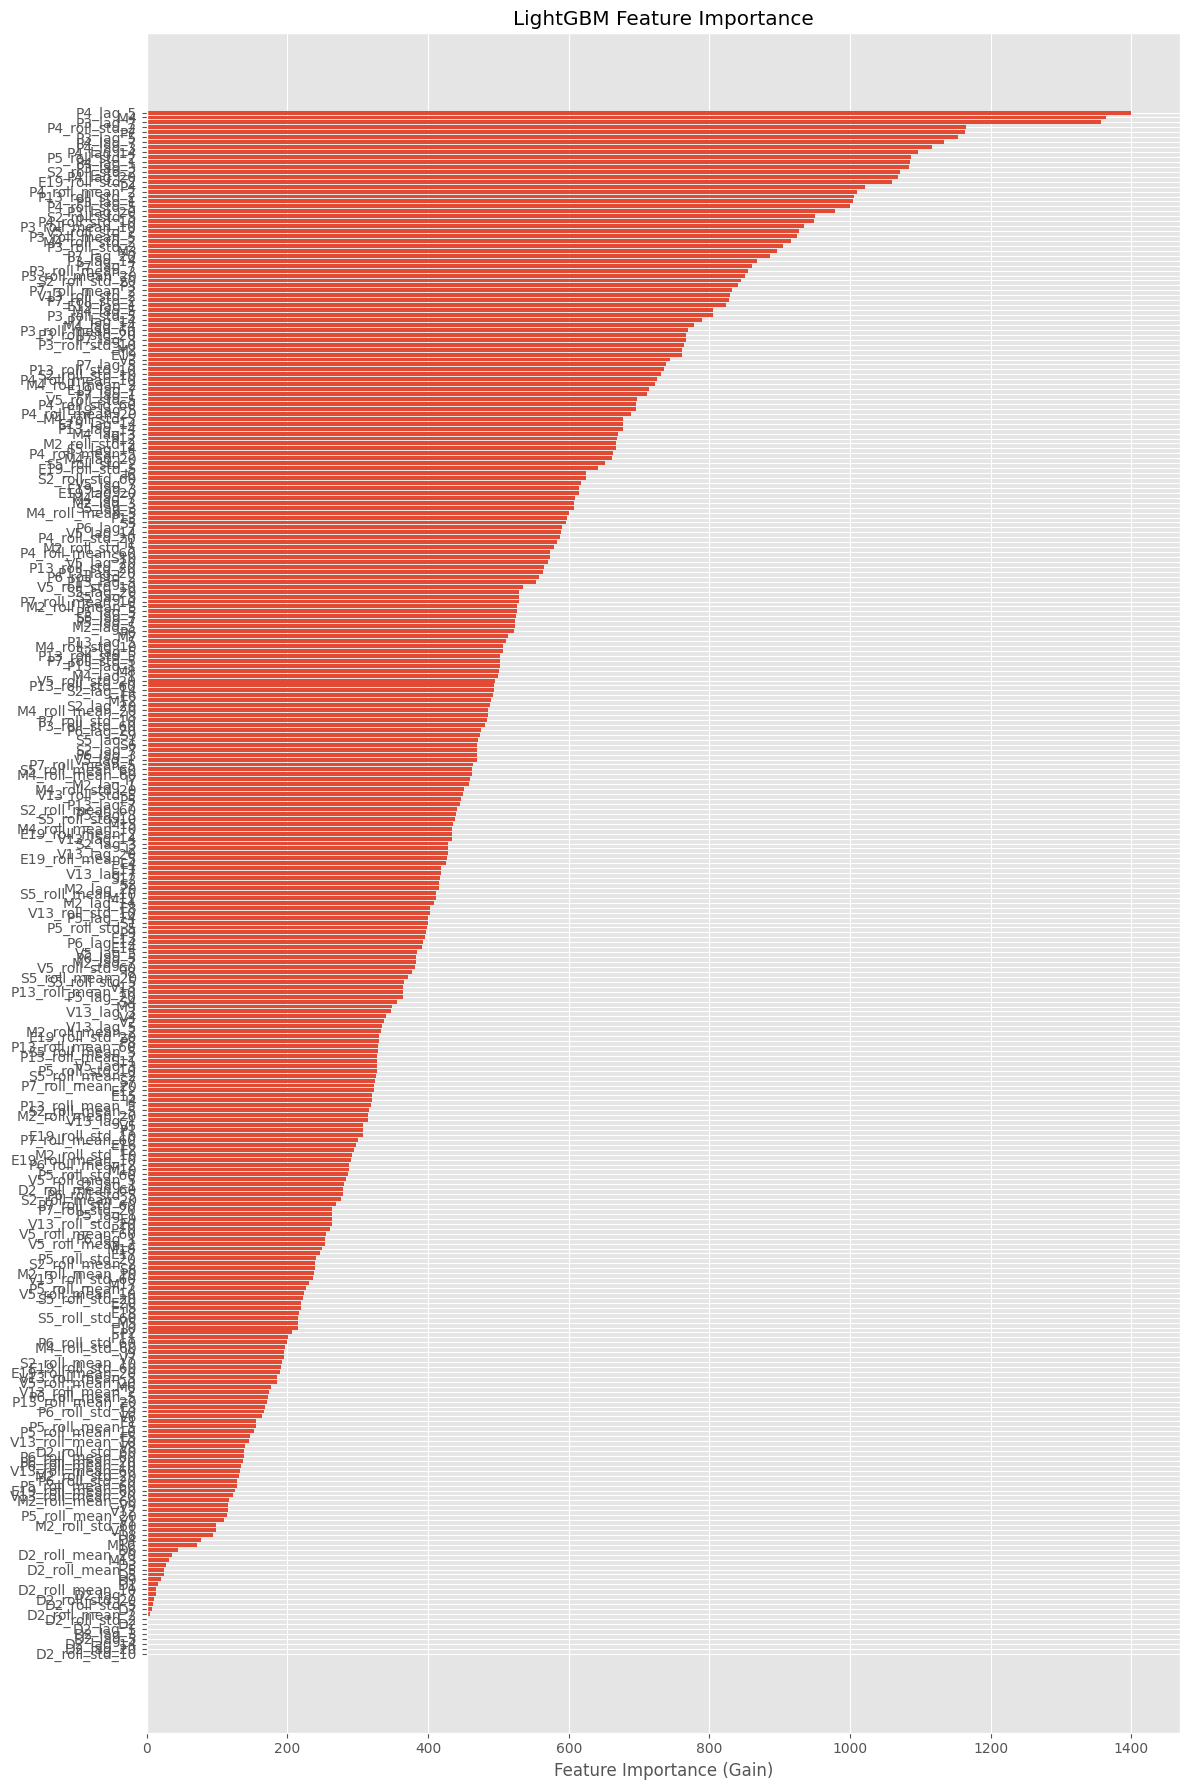

In [13]:
# === Feature Importance Plot ===

importance = final_model.feature_importances_
indices = np.argsort(importance)[::-1]
sorted_features = np.array(FEATURES)[indices]
sorted_importance = importance[indices]

plt.figure(figsize=(12, 18))
plt.barh(sorted_features, sorted_importance)
plt.xlabel("Feature Importance (Gain)")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Step 7-B. Local Evaluation & Backtesting (Sharpe-variant)

최종 모델에 대해 **로컬 백테스트**를 수행한다.  

- 데이터: train set의 마지막 N일 (기본 252 trading days)
- 전략:
  - LightGBM 예측값을 `convert_ret_to_signal`과 동일한 로직으로 신호(0,1,2)로 변환
  - benchmark는 항상 w = 1로 가정
- 지표:
  - Sharpe-like 지표 (평균 / 표준편차)
  - Volatility ratio (strategy vol / benchmark vol)
  - Max drawdown
  - 누적 수익률 곡선 (전략 vs benchmark)


Loaded model for backtest.
Number of features used: 313
Evaluation window length: 252
[Backtest] Sharpe-like (strategy):  0.5554
[Backtest] Sharpe-like (benchmark): 0.0172
[Backtest] Volatility (strategy):   0.0114
[Backtest] Volatility (benchmark):  0.0102
[Backtest] Volatility ratio (S/B):  1.1206
[Backtest] Max Drawdown (strategy):  -0.06%
[Backtest] Max Drawdown (benchmark): -20.69%


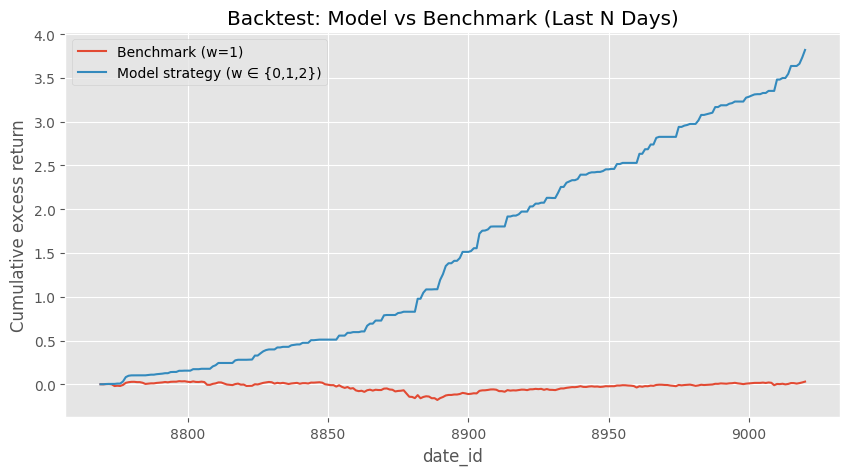

In [14]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1) 최종 모델 & feature 목록 로드 ===
if not (os.path.exists(MODEL_PATH) and os.path.exists(FEATURES_PATH)):
    raise RuntimeError(
        f"Backtest 실패: 모델 또는 feature 파일이 없습니다.\n"
        f"- MODEL_PATH: {MODEL_PATH}\n"
        f"- FEATURES_PATH: {FEATURES_PATH}\n"
        f"먼저 Step 6 (모델 학습) 셀을 실행하여 모델을 저장하세요."
    )

model_bt = joblib.load(MODEL_PATH)
FEATURES_BT = joblib.load(FEATURES_PATH)
print("Loaded model for backtest.")
print("Number of features used:", len(FEATURES_BT))

# === 2) train 전체에 대해 feature engineering 수행 ===
train_bt = pd.read_csv(TRAIN_PATH)

if "date_id" not in train_bt.columns:
    train_bt["date_id"] = train_bt.index

# 학습 시와 동일하게 불필요 컬럼 제거
cols_to_drop_bt = [col for col in COLS_TO_DROP if col in train_bt.columns]
train_bt.drop(columns=cols_to_drop_bt, inplace=True)

train_fe = create_features(train_bt.copy())

# TARGET이 존재하는 행만 사용
mask = train_fe[TARGET].notnull()
train_fe = train_fe[mask].reset_index(drop=True)

# === 3) 전체 feature matrix & 타깃 준비 ===
X_all = train_fe[FEATURES_BT]
y_all = train_fe[TARGET].values

# 평가 구간: 마지막 N일 (예: 252 trading days)
N = 252
if len(train_fe) < N:
    N = len(train_fe)
    print(f"[WARN] train rows < 252, using last {N} rows instead.")

X_eval = X_all.iloc[-N:]
y_eval = y_all[-N:]
dates_eval = train_fe["date_id"].iloc[-N:]

print("Evaluation window length:", N)

# === 4) 모델 예측 ===
preds_eval = model_bt.predict(X_eval.values)

# === 5) convert_ret_to_signal 로 weight 생성 ===
def convert_ret_to_signal_local(ret_arr: np.ndarray) -> np.ndarray:
    """
    원래 inference에서 사용하던 신호 생성 로직과 동일하게 구현.
    - q75 = max(0, 75% quantile)
    - 0: ret <= 0
    - 1: 0 < ret <= q75
    - 2: ret > q75
    """
    q75 = max(0, np.quantile(ret_arr, 0.75))
    signal = np.zeros_like(ret_arr, dtype=int)
    signal[(ret_arr > 0) & (ret_arr <= q75)] = 1
    signal[ret_arr > q75] = 2
    return signal

weights_eval = convert_ret_to_signal_local(preds_eval)

# === 6) 전략/벤치마크 수익률 계산 ===
# 여기서는 TARGET (market_forward_excess_returns)을 excess return으로 사용
excess_series = y_eval  # shape (N,)

strategy_excess = weights_eval * excess_series
benchmark_excess = 1.0 * excess_series  # 항상 w = 1

# === 7) Sharpe-like 지표 & volatility ratio ===
def sharpe_like(x: np.ndarray) -> float:
    return float(x.mean() / (x.std() + 1e-8))

sharpe_strat = sharpe_like(strategy_excess)
sharpe_bench = sharpe_like(benchmark_excess)

vol_strat = float(strategy_excess.std())
vol_bench = float(benchmark_excess.std())
vol_ratio = vol_strat / (vol_bench + 1e-8)

# === 8) 누적 수익률 & Max Drawdown 계산 ===
cum_strat = (1 + strategy_excess).cumprod() - 1
cum_bench = (1 + benchmark_excess).cumprod() - 1

def max_drawdown(cum_ret: np.ndarray) -> float:
    """
    cum_ret: 누적 수익률 (예: 0.1 → 10%)
    """
    equity = 1 + cum_ret
    running_max = np.maximum.accumulate(equity)
    drawdown = equity / running_max - 1
    return float(drawdown.min())

mdd_strat = max_drawdown(cum_strat)
mdd_bench = max_drawdown(cum_bench)

print(f"[Backtest] Sharpe-like (strategy):  {sharpe_strat:.4f}")
print(f"[Backtest] Sharpe-like (benchmark): {sharpe_bench:.4f}")
print(f"[Backtest] Volatility (strategy):   {vol_strat:.4f}")
print(f"[Backtest] Volatility (benchmark):  {vol_bench:.4f}")
print(f"[Backtest] Volatility ratio (S/B):  {vol_ratio:.4f}")
print(f"[Backtest] Max Drawdown (strategy):  {mdd_strat:.2%}")
print(f"[Backtest] Max Drawdown (benchmark): {mdd_bench:.2%}")

# === 9) 누적 수익률 그래프 ===
plt.figure(figsize=(10, 5))
plt.plot(dates_eval, cum_bench, label="Benchmark (w=1)")
plt.plot(dates_eval, cum_strat, label="Model strategy (w ∈ {0,1,2})")
plt.xlabel("date_id")
plt.ylabel("Cumulative excess return")
plt.title("Backtest: Model vs Benchmark (Last N Days)")
plt.legend()
plt.grid(True)
plt.show()


## Step 8. Kaggle Evaluation API용 `predict()` 및 Inference Server 설정

In [15]:
print("Loading artifacts for inference...")
try:
    # Load LightGBM model and features
    model = joblib.load(MODEL_PATH)
    MODEL_FEATURES = joblib.load(FEATURES_PATH)
except Exception as e:
    raise RuntimeError(
        f"Could not load model/features. Ensure training was successful. Error: {e}"
    )

print("Initializing prediction history...")
history_df = pd.read_csv(TRAIN_PATH)

cols_to_drop_hist = [
    col for col in COLS_TO_DROP
    if col in history_df.columns and col != TARGET
]
history_df.drop(columns=cols_to_drop_hist, inplace=True)

if 'date_id' not in history_df.columns:
    history_df['date_id'] = history_df.index

print("Setup complete. Ready for prediction.")

def convert_ret_to_signal(ret_arr: np.ndarray) -> np.ndarray:
    """
    Convert an array of returns to discrete trading signals 0, 1, 2
    """
    q75 = max(0, np.quantile(ret_arr, 0.75))

    signal = np.zeros_like(ret_arr, dtype=int)

    signal[(ret_arr > 0) & (ret_arr <= q75)] = 1

    signal[ret_arr > q75] = 2

    return signal

def predict(test_df_pl: pl.DataFrame) -> float:
    global history_df

    # Convert to pandas
    test_df_pd = test_df_pl.to_pandas()

    # Assign next date_id
    if 'date_id' not in test_df_pd.columns:
        last_date_id = history_df['date_id'].max() if not history_df.empty else -1
        test_df_pd['date_id'] = last_date_id + 1

    # Update history
    history_df = pd.concat([history_df, test_df_pd], ignore_index=True)

    # Slice window for feature creation
    slice_size = max(ROLLING_WINDOWS) + max(LAG_PERIODS) + 5
    historical_slice = history_df.tail(slice_size)

    processed_slice = create_features(historical_slice)

    # Select only model feature columns (LightGBM)
    current_features = processed_slice.tail(1)[MODEL_FEATURES]

    # Predict
    prediction = model.predict(current_features)[0]

    signals = convert_ret_to_signal(prediction)
    # # Allocation calculation
    # allocation = np.clip(1 + BEST_C * prediction, 0, 2)

    gc.collect()

    return float(signals)


# Inference server setup
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    print("Serving predictions for the competition...")
    inference_server.serve()
else:
    print("Running local gateway for testing...")
    inference_server.run_local_gateway((LOCAL_GATEWAY_PATH,))

print("Submission script finished.")

Loading artifacts for inference...
Initializing prediction history...
Setup complete. Ready for prediction.
Running local gateway for testing...
Submission script finished.
